In [18]:
import os
from tempfile import tempdir
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import importlib

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms

importlib.reload(icrms)



<module 'corems.lc_icpms_ftms.calc.lc_icrms_qc_assign' from '/Users/christiandewey/CoreMS/corems/lc_icpms_ftms/calc/lc_icrms_qc_assign.py'>

In [19]:
def getParser(file):
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file)
    return parser

def assign_formula(parser, interval, timerange, refmasslist=None):
    #Function to build formula assignment lists
    #Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)    
        mass_spectrum.molecular_search_settings.ion_charge = 1

        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()

        if refmasslist:
            mass_spectrum.settings.min_calib_ppm_error = 10
            mass_spectrum.settings.max_calib_ppm_error = -10
            calfn = MzDomainCalibration(mass_spectrum, refmasslist)
            ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

            imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                        calib_ppm_error_threshold=(0, 2.0),
                                                        calib_snr_threshold=3)

            calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
    
    results=pd.concat(results,ignore_index=True)

    return(results)    


In [20]:
def plot_ms(df1, start_mz, end_mz, tstart=None, df2=None,df3=None, assignment= None, ax_ms=None, lbls=None, norm=False, labs=False, colors=None):   
    
    if ax_ms == None:
        _, ax = plt.subplots()
    
    else:
        ax = ax_ms

    if colors is not None:
        cols = colors
    else:
        cols = ['C0', 'C1', 'C2']
    mzrange= end_mz - start_mz

    if tstart != None:
        ms_t_int=df1[df1['Time'] == tstart]
    else:
        ms_t_int=df1

    ms_df = ms_t_int[((ms_t_int['Calibrated m/z']-start_mz)<mzrange) & ((ms_t_int['Calibrated m/z']-start_mz)>0)]


    if norm:

        pltcol = 'Normalized Peak Height'

    else:
        pltcol = 'S/N'

    
    if lbls is not None:
        labels = lbls
    else:
        labels = [None, None, None]

 
    _, stemlines1, _ =ax.stem('Calibrated m/z',pltcol,data=ms_df,  markerfmt=' ', basefmt=' ', linefmt=cols[0], label = labels[0])
    
    if (df2 is not None) and (len(df2['Molecular Formula'])>0):
        pltdf2 = True
        if tstart != None:
            ms_t_int2=df2[df2['Time'] == tstart]
        else:
            ms_t_int2=df2

        ms_df2 = ms_t_int2[(abs(ms_t_int2['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int2['Calibrated m/z']-start_mz)>0)]
        
        _, stemlines2, _ =ax.stem('Calibrated m/z',pltcol,data=ms_df2,  markerfmt=' ', basefmt=' ', linefmt=cols[1], label = labels[1])
    else:
        pltdf2 = False 

    if (df3 is not None) and (len(df3['Molecular Formula'])>0):
        pltdf3 = True
        if tstart != None:
            ms_t_int3=df3[df3['Time'] == tstart]
        else:
            ms_t_int3=df3

        ms_df3 = ms_t_int3[(abs(ms_t_int3['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int3['Calibrated m/z']-start_mz)>0)]

        
        _, stemlines3, _ =ax.stem('Calibrated m/z',pltcol,data=ms_df3,  markerfmt=' ', basefmt=' ', linefmt=cols[2], label = labels[2])
    else:
        pltdf3 = False
    #if pltdf3 is True:
    #    ax.set_ylim(0, max([maxdf1, maxdf2, maxdf3]) * 1.1)
    #elif pltdf2 is True:
    #    ax.set_ylim(0, max([maxdf1, maxdf2]) * 1.1)
    #else: 
    #    ax.set_ylim(0, maxdf1 * 1.1)

    ax.set_xlim(left = start_mz - mzrange*0.1, right = start_mz + mzrange + mzrange*0.1) 

    if labs:
        for mzr,peakr,mf,er in zip(ms_df['Calibrated m/z'], ms_df[pltcol], ms_df['Molecular Formula'],  ms_df['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

            mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
            ax.text(mzr, peakr + 0.02 *max(ms_df[pltcol]), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color=cols[0])

        if df2 is not None:

            for mzr,peakr,mf, er in zip(ms_df2['Calibrated m/z'], ms_df2[pltcol], ms_df2['Molecular Formula'], ms_df2['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df2[pltcol]), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[1])

        if df3 is not None:

            for mzr,peakr,mf, er in zip(ms_df3['Calibrated m/z'], ms_df3[pltcol], ms_df3['Molecular Formula'], ms_df3['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df3[pltcol]), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[2])

   # theor_mz=pattern.mdiff+result['mass']
   # theor_int=pattern.ratio*result['abundance']
   # ax.stem(theor_mz,theor_int, basefmt=' ',linefmt='gray')

   # for isotope in pattern.isotope[pattern.requirement=='Y']:
   #     ax.stem('mz','intense',data=result[isotope],  markerfmt=' ', basefmt=' ',linefmt='red')
    ax.set_xlim(start_mz, end_mz)
    
    if ax == None:

        ax.legend(('other', 'target'),bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)

        if(assignment):

            mf = assignment[0]
            score = assignment[1]
            er = assignment[2]

            ax.text(1.05,0.7,mf,transform=ax.transAxes)
            ax.text(1.05,0.6,'Error (ppm) = %.3f ' %er ,transform=ax.transAxes)
            ax.text(1.05,0.5,'Score = %.3f' %score ,transform=ax.transAxes)

    if norm: 
        ax.set(xlabel='Calibrated m/z',ylabel='Normalized Intensity')
    else: 
        ax.set(xlabel='Calibrated m/z',ylabel='Intensity')
    #ax.set_title('%.2f' %timerange[0] + ' to %.2f' %timerange[1] +' min', fontsize = 'medium')
    ax.legend(bbox_to_anchor = (1.00, 0.5), frameon =False, loc = 'center left')
    ax.axhline(y=0.0, color='black')
    plt.setp(stemlines1,'color', cols[0], 'linewidth', 2)
    if pltdf2 is True:
        plt.setp(stemlines2, 'color', cols[1],'linewidth', 2, 'linestyle', '--')
    if pltdf3 is True:
        plt.setp(stemlines3, 'color', cols[2],'linewidth', 2)
    plt.tight_layout()
    if ax_ms != None:
        return ax






In [21]:
def filterMzRange(results, mz_range):

    mz_i = mz_range[0]
    mz_f = mz_range[1]

    sub = results[(results['m/z'] >= mz_i) & (results['m/z'] <= mz_f)]

    return sub



In [22]:
def pltMZerror(results, bins=50):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        counts, bins = np.histogram(np.asarray(results[results['mol_class']==mol_class]['m/z Error (ppm)']),bins = bins)

        ax.plot(bins[:-1], counts, label = mol_class)

    ax.set_xlim(-0.5,0.5)
    ax.legend(frameon=False)
    ax.set_xlabel('m/z assignment error (ppm)')
    ax.set_ylabel('# assigned features')

    return ax

def pltMZerror_pts(results):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        ax.scatter(results[results['mol_class']==mol_class]['Calibrated m/z'], results[results['mol_class']==mol_class]['m/z Error (ppm)'], label = mol_class)

    ax.set_xlim(200,1200)
    ax.legend(frameon=False,bbox_to_anchor=(1.0, 0.5))
    ax.set_xlabel('calibrated m/z')
    ax.set_ylabel('assignment error (ppm)')

    return ax


In [23]:
def assignMolClass(resultsdf, mz_cutoff = 800, sn_lim = 3):

    filtered_results=resultsdf[(resultsdf['m/z']<mz_cutoff) & (resultsdf['S/N']>sn_lim)]

    filtered_results['N']=filtered_results['N'].fillna(0)
    filtered_results['O']=filtered_results['O'].fillna(0)
    #filtered_results['S']=filtered_results['S'].fillna(0)
    #filtered_results['P']=filtered_results['Fe'].fillna(0)
    filtered_results['Cu']=filtered_results['Cu'].fillna(0)

    filtered_results['mol_class']='Unassigned'
    filtered_results['mol_class'][filtered_results['C']>0]='CHO'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['N']>0.5)]='CHON'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['S']>0.5)]='CHOS'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Fe']>0.5)]='CHOFe'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5)]='CHOCu'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['N']>0.5)]='CHONCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['S']>0.5)]='CHOSCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['N']>0.5) & (filtered_results['S']>0.5)] ='CHONSCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONNa'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['P']>0.5) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONPNa'


    results= filtered_results #[filtered_results['mol_class'] != 'Unassigned'] #[filtered_results['Is Isotopologue']==0]
    results['N/C']=results['O']/results['C']
    results['H/C']=results['H']/results['C']
    results['N/C']=results['N']/results['C']

    return results



In [24]:
def add_mzwindow_col(df):    

    df['m/z window'] = df.index
    
    
    for file, r in zip(df['file'], range(len(df['file']))):

        if ('400_500' in file) or ('400-500' in file):

            df['m/z window'].iloc[r] = '400-500 m/z'

        elif ('500_600' in file) or ('500-600' in file):

            df['m/z window'].iloc[r] = '500-600 m/z'
    
        elif ('600_700' in file) or ('600-700' in file):

            df['m/z window'].iloc[r] = '600-700 m/z'

        elif ('700_800' in file) or ('700-800' in file):

            df['m/z window'].iloc[r] = '700-800 m/z'

        elif ('400_600' in file) or ('400-600' in file):

            df['m/z window'].iloc[r] = '400-600 m/z'
        
        elif ('600_800' in file) or ('600-800' in file):

            df['m/z window'].iloc[r] = '600-800 m/z'
            
        elif 'full' in file:

            df['m/z window'].iloc[r] = '200-1200 m/z'

    return df 

In [25]:
def getUniqueFeatures(df):    
    #Create a list of all unique features and describe their intensity. 
    print('total # results: %s' %len(df))
    #define a list of unique features (time, formula) with 'areas' determined for each sample. There may be a slight bug that causes the unique list to grow...
    uniquelist=[]
    for time in df.Time.unique():
        current=df[df.Time==time]
        current=current.sort_values(by=['m/z Error (ppm)'],ascending=True)
        currentunique=current.drop_duplicates(subset=['Molecular Formula'])
        currentunique=currentunique[currentunique['C']>1]
        currentunique=currentunique.set_index(['Molecular Formula'],drop=False)
        for file in df['file'].unique():
            current_file=current[current['file']==file].drop_duplicates(subset=['Molecular Formula'])
            current_file=current_file.rename(columns={'Peak Height':file})
            current_file=current_file.set_index(['Molecular Formula'],drop=False)
            #current_file[file].fillna(0)
            currentunique=currentunique.join(current_file[file])
        uniquelist.append(currentunique)

    unique_results=pd.concat(uniquelist,ignore_index=True)
    unique_results['N/C']=unique_results['N']/unique_results['C']
    #unique_results['blank']=unique_results[blankfile]/unique_results['Peak Height']
    #unique_results=unique_results[unique_results['blank']<blnk_thresh]


    print('# unique results: %s' %len(unique_results))

    return unique_results


In [48]:
def plotUnique(df,ps=50,includeBlanks=False, xlim = [400,600]):
    xmin = xlim[0]
    xmax = xlim[1]
    if includeBlanks != True:
        mask = ~df['file'].str.contains('qh2o', case=False, na=False)
        df=df[mask]
    else:
        df=df
    fig, ((ax2, ax4),(ax3, ax1)) = plt.subplots(2,2,figsize = (12,12))
    sns.scatterplot(x='m/z',y='m/z Error (ppm)',data=df[df['Cu']>0],hue='m/z window', s=ps*4, ax=ax1)
    sns.scatterplot(x='m/z',y='m/z Error (ppm)', hue='m/z window', data=df, ax=ax2,s=ps)
    ax1.set_xlim(xmin,xmax)
    ax2.set_xlim(xmin,xmax)
    sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='N',data=df,ax=ax3,s=ps)
    sns.scatterplot(x='m/z',y='Resolving Power',hue='mol_class',data=df,ax=ax4)
    
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.set_title('Assignment error, Cu features')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_title('Overall assignment error')
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.set_title('Assignment error, N features')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax4.set_title('Resolving power v. m/z')

    #fig.savefig('unique_results.pdf', bbox_to_inches='tight')

    return fig

    

In [27]:
def addRepCol(data_df):

    data_df['Rep'] = data_df.index


    for file in data_df['file'].unique():

        print(file)

        if 'rep2' in file:

            temp = data_df[data_df['file'] == file]
            temp['Rep'] = 2
            data_df[data_df['file'] == file] = temp


        else:

            temp = data_df[data_df['file'] == file]
            temp['Rep'] = 1
            data_df[data_df['file'] == file] = temp

    print(data_df['Rep'].unique())


    return data_df 

In [28]:
def blankSubtract(df, blnkthresh = 0.9):
    
    holder = []
    for file in df['file'].unique():
        
        sub = df[df['file'] == file]

        blkf = sub['blank file'].iloc[0]


        sub[sub[file]== np.nan] = 0

        nom = sub[file]
        den = sub[blkf]

        nom = nom.replace(np.nan,0)
        den = den.replace(np.nan,1)

        if file != blkf:
            nom = nom
        elif file == blkf:
            nom = nom * (blnkthresh*0.8)

        sub['blank subtract'] = nom/den
        holder.append(sub)
    df_end = pd.concat(holder)
    df_end = df_end[df_end['blank subtract'] > blnkthresh]
    return df_end

In [29]:
def normMS(df,fulldf):

    max_i = max(fulldf['Peak Height'].values)

    df['Normalized Peak Height'] = df['Peak Height'] / max_i

    return df

In [30]:
dir='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/lowmz-r1/'
flist=os.listdir(dir)
os.chdir(dir)

print(flist)
MSfiles={}

for f in flist:
    if '.raw' in f:
        print(f)
        parser = rawFileReader.ImportMassSpectraThermoMSFileReader(f)
        MSfiles[f]={'parser': parser}


['.DS_Store', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw', 'narrow', '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw']
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw


In [31]:
data = icrms.lc_icr_assign(dir)

data.master_data_holder = MSfiles

print(data.master_data_holder.keys())
data._raw_filelist = data.master_data_holder.keys()


dict_keys(['20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw'])


In [32]:
# set assignment parameters
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"


MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
MSParameters.molecular_search.usedAtoms['Cu'] = (0,1)


In [33]:
# run assignment algorithm
timerange = [6,22]  # start (min) to stop (min)
interval = 2  # min 
refmasslist = "/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref"

data.assign_formula(interval = interval, timerange = timerange, refmasslist = refmasslist, calorder =2)




20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
1 of 7 files
timestart: 6
MS Obj loaded - 2128 peaks found.
MS Obj loaded - 2128 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
62 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 326 fn evals and 4 iterations


100%|██████████| 200/200 [00:00<00:00, 1115.51it/s]


Started database insert using 5244 iterations for a total of 262195 rows


5244it [00:07, 730.87it/s]


'runworker'  7670.50 ms


Loading molecular formula database: 168198it [00:05, 32148.81it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 94.87it/s]


'run_molecular_formula'  15069.82 ms
1130 assigned peaks and 998 unassigned peaks, total  = 53.10 %, relative abundance = 55.28 %, RMS error (best candidate) (ppm) = 0.046
timestart: 8
MS Obj loaded - 2816 peaks found.
MS Obj loaded - 2816 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
87 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 273 fn evals and 3 iterations
'runworker'  4.70 ms


Loading molecular formula database: 168198it [00:04, 34351.34it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 71.36it/s]


'run_molecular_formula'  7760.58 ms
1610 assigned peaks and 1206 unassigned peaks, total  = 57.17 %, relative abundance = 63.82 %, RMS error (best candidate) (ppm) = 0.049
timestart: 10
MS Obj loaded - 3077 peaks found.
MS Obj loaded - 3077 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
119 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 366 fn evals and 7 iterations
'runworker'  5.06 ms


Loading molecular formula database: 168198it [00:04, 37237.95it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 64.99it/s]


'run_molecular_formula'  7656.10 ms
1893 assigned peaks and 1184 unassigned peaks, total  = 61.52 %, relative abundance = 67.62 %, RMS error (best candidate) (ppm) = 0.055
timestart: 12
MS Obj loaded - 3549 peaks found.
MS Obj loaded - 3549 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
143 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 370 fn evals and 7 iterations
'runworker'  4.90 ms


Loading molecular formula database: 168198it [00:04, 34212.75it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 55.02it/s]


'run_molecular_formula'  8615.55 ms
2229 assigned peaks and 1320 unassigned peaks, total  = 62.81 %, relative abundance = 71.51 %, RMS error (best candidate) (ppm) = 0.047
timestart: 14
MS Obj loaded - 3768 peaks found.
MS Obj loaded - 3768 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
153 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 363 fn evals and 7 iterations
'runworker'  4.61 ms


Loading molecular formula database: 168198it [00:04, 33721.37it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 53.49it/s]


'run_molecular_formula'  8787.82 ms
2416 assigned peaks and 1352 unassigned peaks, total  = 64.12 %, relative abundance = 76.20 %, RMS error (best candidate) (ppm) = 0.051
timestart: 16
MS Obj loaded - 3452 peaks found.
MS Obj loaded - 3452 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
162 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 360 fn evals and 7 iterations
'runworker'  4.92 ms


Loading molecular formula database: 168198it [00:04, 34549.64it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 58.76it/s]


'run_molecular_formula'  8332.91 ms
2297 assigned peaks and 1155 unassigned peaks, total  = 66.54 %, relative abundance = 78.78 %, RMS error (best candidate) (ppm) = 0.048
timestart: 18
MS Obj loaded - 3759 peaks found.
MS Obj loaded - 3759 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
166 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 366 fn evals and 7 iterations
'runworker'  4.67 ms


Loading molecular formula database: 168198it [00:04, 37177.94it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 53.51it/s]


'run_molecular_formula'  8323.28 ms
2519 assigned peaks and 1240 unassigned peaks, total  = 67.01 %, relative abundance = 81.02 %, RMS error (best candidate) (ppm) = 0.050
timestart: 20
MS Obj loaded - 3919 peaks found.
MS Obj loaded - 3919 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
167 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 361 fn evals and 7 iterations
'runworker'  109.35 ms


Loading molecular formula database: 168198it [00:04, 33962.44it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 50.72it/s]


'run_molecular_formula'  9062.00 ms
2674 assigned peaks and 1245 unassigned peaks, total  = 68.23 %, relative abundance = 82.84 %, RMS error (best candidate) (ppm) = 0.054


20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
2 of 7 files
timestart: 6
MS Obj loaded - 2758 peaks found.
MS Obj loaded - 2758 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
117 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 352 fn evals and 4 iterations
'runworker'  4.90 ms


Loading molecular formula database: 168198it [00:06, 26296.37it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 76.76it/s]


'run_molecular_formula'  9111.50 ms
1557 assigned peaks and 1201 unassigned peaks, total  = 56.45 %, relative abundance = 59.92 %, RMS error (best candidate) (ppm) = 0.033
timestart: 8
MS Obj loaded - 3769 peaks found.
MS Obj loaded - 3769 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
156 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.015 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  5.53 ms


Loading molecular formula database: 168198it [00:06, 24878.13it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 54.50it/s]


'run_molecular_formula'  10566.53 ms
2117 assigned peaks and 1652 unassigned peaks, total  = 56.17 %, relative abundance = 63.44 %, RMS error (best candidate) (ppm) = 0.037
timestart: 10
MS Obj loaded - 4003 peaks found.
MS Obj loaded - 4003 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
195 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 321 fn evals and 6 iterations
'runworker'  4.78 ms


Loading molecular formula database: 168198it [00:07, 23364.88it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 50.43it/s]


'run_molecular_formula'  11299.08 ms
2453 assigned peaks and 1550 unassigned peaks, total  = 61.28 %, relative abundance = 70.78 %, RMS error (best candidate) (ppm) = 0.041
timestart: 12
MS Obj loaded - 4329 peaks found.
MS Obj loaded - 4329 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
226 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 327 fn evals and 6 iterations
'runworker'  6.19 ms


Loading molecular formula database: 168198it [00:06, 24303.62it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:04<00:00, 46.65it/s]


'run_molecular_formula'  11350.98 ms
2727 assigned peaks and 1602 unassigned peaks, total  = 62.99 %, relative abundance = 74.31 %, RMS error (best candidate) (ppm) = 0.043
timestart: 14
MS Obj loaded - 4619 peaks found.
MS Obj loaded - 4619 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
246 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 324 fn evals and 6 iterations
'runworker'  4.85 ms


Loading molecular formula database: 168198it [00:07, 23804.49it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:04<00:00, 44.14it/s]


'run_molecular_formula'  11745.32 ms
3005 assigned peaks and 1614 unassigned peaks, total  = 65.06 %, relative abundance = 78.32 %, RMS error (best candidate) (ppm) = 0.045
timestart: 16
MS Obj loaded - 4899 peaks found.
MS Obj loaded - 4899 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
257 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.014 ppm
minimize function performed 3020 fn evals and 69 iterations
'runworker'  4.72 ms


Loading molecular formula database: 168198it [00:07, 22091.40it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:04<00:00, 41.26it/s]


'run_molecular_formula'  12611.81 ms
3157 assigned peaks and 1742 unassigned peaks, total  = 64.44 %, relative abundance = 80.19 %, RMS error (best candidate) (ppm) = 0.050
timestart: 18
MS Obj loaded - 5289 peaks found.
MS Obj loaded - 5289 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
268 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 470 fn evals and 10 iterations
'runworker'  4.92 ms


Loading molecular formula database: 168198it [00:07, 23432.17it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:05<00:00, 37.13it/s]


'run_molecular_formula'  12715.45 ms
3433 assigned peaks and 1856 unassigned peaks, total  = 64.91 %, relative abundance = 81.46 %, RMS error (best candidate) (ppm) = 0.064
timestart: 20
MS Obj loaded - 5527 peaks found.
MS Obj loaded - 5527 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
262 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 3029 fn evals and 71 iterations
'runworker'  4.78 ms


Loading molecular formula database: 168198it [00:07, 22615.25it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:05<00:00, 36.17it/s]


'run_molecular_formula'  13116.69 ms
3694 assigned peaks and 1833 unassigned peaks, total  = 66.84 %, relative abundance = 82.05 %, RMS error (best candidate) (ppm) = 0.056


20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
3 of 7 files
timestart: 6
MS Obj loaded - 1591 peaks found.
MS Obj loaded - 1591 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
52 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 260 fn evals and 3 iterations
'runworker'  4.58 ms


Loading molecular formula database: 168198it [00:03, 42592.76it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 135.42it/s]


'run_molecular_formula'  5463.04 ms
871 assigned peaks and 720 unassigned peaks, total  = 54.75 %, relative abundance = 58.20 %, RMS error (best candidate) (ppm) = 0.040
timestart: 8
MS Obj loaded - 1981 peaks found.
MS Obj loaded - 1981 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
75 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 257 fn evals and 3 iterations
'runworker'  4.55 ms


Loading molecular formula database: 168198it [00:04, 37282.26it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 113.95it/s]


'run_molecular_formula'  6301.43 ms
1137 assigned peaks and 844 unassigned peaks, total  = 57.40 %, relative abundance = 65.10 %, RMS error (best candidate) (ppm) = 0.040
timestart: 10
MS Obj loaded - 2115 peaks found.
MS Obj loaded - 2115 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
86 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.014 ppm
minimize function performed 372 fn evals and 7 iterations
'runworker'  4.80 ms


Loading molecular formula database: 168198it [00:03, 44422.94it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 106.09it/s]


'run_molecular_formula'  5706.76 ms
1298 assigned peaks and 817 unassigned peaks, total  = 61.37 %, relative abundance = 68.18 %, RMS error (best candidate) (ppm) = 0.046
timestart: 12
MS Obj loaded - 2461 peaks found.
MS Obj loaded - 2461 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
101 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 367 fn evals and 7 iterations
'runworker'  4.62 ms


Loading molecular formula database: 168198it [00:04, 37426.88it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 92.64it/s]


'run_molecular_formula'  6688.34 ms
1486 assigned peaks and 975 unassigned peaks, total  = 60.38 %, relative abundance = 72.80 %, RMS error (best candidate) (ppm) = 0.047
timestart: 14
MS Obj loaded - 2508 peaks found.
MS Obj loaded - 2508 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
108 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 372 fn evals and 7 iterations
'runworker'  4.71 ms


Loading molecular formula database: 168198it [00:04, 40157.35it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 90.35it/s]


'run_molecular_formula'  6438.11 ms
1556 assigned peaks and 952 unassigned peaks, total  = 62.04 %, relative abundance = 76.93 %, RMS error (best candidate) (ppm) = 0.046
timestart: 16
MS Obj loaded - 2527 peaks found.
MS Obj loaded - 2527 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
117 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.015 ppm
minimize function performed 371 fn evals and 7 iterations
'runworker'  4.59 ms


Loading molecular formula database: 168198it [00:03, 43959.83it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 90.29it/s]


'run_molecular_formula'  6076.48 ms
1598 assigned peaks and 929 unassigned peaks, total  = 63.24 %, relative abundance = 79.21 %, RMS error (best candidate) (ppm) = 0.048
timestart: 18
MS Obj loaded - 2598 peaks found.
MS Obj loaded - 2598 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
118 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 374 fn evals and 7 iterations
'runworker'  4.82 ms


Loading molecular formula database: 168198it [00:04, 40879.51it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 91.01it/s]


'run_molecular_formula'  6346.59 ms
1688 assigned peaks and 910 unassigned peaks, total  = 64.97 %, relative abundance = 81.89 %, RMS error (best candidate) (ppm) = 0.047
timestart: 20
MS Obj loaded - 2489 peaks found.
MS Obj loaded - 2489 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
119 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  4.85 ms


Loading molecular formula database: 168198it [00:04, 39793.56it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 91.15it/s]


'run_molecular_formula'  6456.84 ms
1683 assigned peaks and 806 unassigned peaks, total  = 67.62 %, relative abundance = 83.82 %, RMS error (best candidate) (ppm) = 0.049


20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
4 of 7 files
timestart: 6
MS Obj loaded - 876 peaks found.
MS Obj loaded - 876 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
12 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 271 fn evals and 3 iterations
'runworker'  4.72 ms


Loading molecular formula database: 168198it [00:04, 37265.54it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 200.66it/s]


'run_molecular_formula'  5553.31 ms
479 assigned peaks and 397 unassigned peaks, total  = 54.68 %, relative abundance = 54.72 %, RMS error (best candidate) (ppm) = 0.055
timestart: 8
MS Obj loaded - 1139 peaks found.
MS Obj loaded - 1139 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
22 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 263 fn evals and 3 iterations
'runworker'  5.82 ms


Loading molecular formula database: 168198it [00:04, 38695.53it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 156.64it/s]


'run_molecular_formula'  5667.55 ms
688 assigned peaks and 451 unassigned peaks, total  = 60.40 %, relative abundance = 62.95 %, RMS error (best candidate) (ppm) = 0.060
timestart: 10
MS Obj loaded - 1323 peaks found.
MS Obj loaded - 1323 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
36 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 842 fn evals and 12 iterations
'runworker'  4.93 ms


Loading molecular formula database: 168198it [00:04, 40895.26it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 136.14it/s]


'run_molecular_formula'  5624.27 ms
855 assigned peaks and 468 unassigned peaks, total  = 64.63 %, relative abundance = 68.27 %, RMS error (best candidate) (ppm) = 0.060
timestart: 12
MS Obj loaded - 1572 peaks found.
MS Obj loaded - 1572 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
43 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.014 ppm
minimize function performed 680 fn evals and 10 iterations
'runworker'  4.57 ms


Loading molecular formula database: 168198it [00:04, 38581.03it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 111.67it/s]


'run_molecular_formula'  6194.64 ms
1039 assigned peaks and 533 unassigned peaks, total  = 66.09 %, relative abundance = 68.66 %, RMS error (best candidate) (ppm) = 0.064
timestart: 14
MS Obj loaded - 1751 peaks found.
MS Obj loaded - 1751 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
47 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 727 fn evals and 10 iterations
'runworker'  4.85 ms


Loading molecular formula database: 168198it [00:04, 39643.89it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 104.11it/s]


'run_molecular_formula'  6207.09 ms
1176 assigned peaks and 575 unassigned peaks, total  = 67.16 %, relative abundance = 74.60 %, RMS error (best candidate) (ppm) = 0.061
timestart: 16
MS Obj loaded - 1781 peaks found.
MS Obj loaded - 1781 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
51 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 379 fn evals and 7 iterations
'runworker'  4.90 ms


Loading molecular formula database: 168198it [00:04, 38757.14it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 102.79it/s]


'run_molecular_formula'  6328.28 ms
1227 assigned peaks and 554 unassigned peaks, total  = 68.89 %, relative abundance = 77.02 %, RMS error (best candidate) (ppm) = 0.067
timestart: 18
MS Obj loaded - 1779 peaks found.
MS Obj loaded - 1779 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
50 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 370 fn evals and 7 iterations
'runworker'  4.60 ms


Loading molecular formula database: 168198it [00:04, 36757.08it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 103.40it/s]


'run_molecular_formula'  6552.29 ms
1241 assigned peaks and 538 unassigned peaks, total  = 69.76 %, relative abundance = 78.45 %, RMS error (best candidate) (ppm) = 0.067
timestart: 20
MS Obj loaded - 1815 peaks found.
MS Obj loaded - 1815 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
50 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  4.87 ms


Loading molecular formula database: 168198it [00:03, 42698.33it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:01<00:00, 100.99it/s]


'run_molecular_formula'  5962.78 ms
1280 assigned peaks and 535 unassigned peaks, total  = 70.52 %, relative abundance = 79.88 %, RMS error (best candidate) (ppm) = 0.064


20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
5 of 7 files
timestart: 6
MS Obj loaded - 149 peaks found.
MS Obj loaded - 149 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.33 ms


Loading molecular formula database: 168198it [00:04, 38974.88it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 802.35it/s]


'run_molecular_formula'  4592.76 ms
3 assigned peaks and 146 unassigned peaks, total  = 2.01 %, relative abundance = 0.35 %, RMS error (best candidate) (ppm) = 0.108
timestart: 8
MS Obj loaded - 190 peaks found.
MS Obj loaded - 190 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  4.83 ms


Loading molecular formula database: 168198it [00:03, 42511.45it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 876.47it/s]


'run_molecular_formula'  4213.82 ms
7 assigned peaks and 183 unassigned peaks, total  = 3.68 %, relative abundance = 0.42 %, RMS error (best candidate) (ppm) = 0.142
timestart: 10
MS Obj loaded - 222 peaks found.
MS Obj loaded - 222 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  4.88 ms


Loading molecular formula database: 168198it [00:03, 44690.77it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 795.96it/s]


'run_molecular_formula'  4044.38 ms
7 assigned peaks and 215 unassigned peaks, total  = 3.15 %, relative abundance = 0.66 %, RMS error (best candidate) (ppm) = 0.119
timestart: 12
MS Obj loaded - 268 peaks found.
MS Obj loaded - 268 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  4.76 ms


Loading molecular formula database: 168198it [00:04, 40015.47it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 691.88it/s]


'run_molecular_formula'  4522.44 ms
7 assigned peaks and 261 unassigned peaks, total  = 2.61 %, relative abundance = 0.80 %, RMS error (best candidate) (ppm) = 0.170
timestart: 14
MS Obj loaded - 400 peaks found.
MS Obj loaded - 400 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  4.91 ms


Loading molecular formula database: 168198it [00:03, 42716.56it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 511.36it/s]


'run_molecular_formula'  4362.83 ms
12 assigned peaks and 388 unassigned peaks, total  = 3.00 %, relative abundance = 1.14 %, RMS error (best candidate) (ppm) = 0.129
timestart: 16
MS Obj loaded - 430 peaks found.
MS Obj loaded - 430 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
4 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.000 ppm
minimize function performed 1206 fn evals and 16 iterations
'runworker'  4.77 ms


Loading molecular formula database: 168198it [00:04, 41787.77it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 442.54it/s]


'run_molecular_formula'  4511.51 ms
185 assigned peaks and 245 unassigned peaks, total  = 43.02 %, relative abundance = 32.54 %, RMS error (best candidate) (ppm) = 0.109
timestart: 18
MS Obj loaded - 506 peaks found.
MS Obj loaded - 506 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
9 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 589 fn evals and 8 iterations
'runworker'  4.68 ms


Loading molecular formula database: 168198it [00:04, 37474.22it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 382.37it/s]


'run_molecular_formula'  5045.65 ms
226 assigned peaks and 280 unassigned peaks, total  = 44.66 %, relative abundance = 33.19 %, RMS error (best candidate) (ppm) = 0.109
timestart: 20
MS Obj loaded - 445 peaks found.
MS Obj loaded - 445 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
8 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 577 fn evals and 8 iterations
'runworker'  4.62 ms


Loading molecular formula database: 168198it [00:03, 44705.55it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 427.25it/s]


'run_molecular_formula'  4264.29 ms
231 assigned peaks and 214 unassigned peaks, total  = 51.91 %, relative abundance = 38.83 %, RMS error (best candidate) (ppm) = 0.093


20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
6 of 7 files
timestart: 6
MS Obj loaded - 83 peaks found.
MS Obj loaded - 83 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.05 ms


Loading molecular formula database: 168198it [00:04, 39767.92it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 948.45it/s]


'run_molecular_formula'  4470.95 ms
8 assigned peaks and 75 unassigned peaks, total  = 9.64 %, relative abundance = 4.08 %, RMS error (best candidate) (ppm) = 0.165
timestart: 8
MS Obj loaded - 92 peaks found.
MS Obj loaded - 92 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.07 ms


Loading molecular formula database: 168198it [00:03, 45193.58it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 1118.69it/s]


'run_molecular_formula'  3932.45 ms
6 assigned peaks and 86 unassigned peaks, total  = 6.52 %, relative abundance = 2.93 %, RMS error (best candidate) (ppm) = 0.173
timestart: 10
MS Obj loaded - 94 peaks found.
MS Obj loaded - 94 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  4.91 ms


Loading molecular formula database: 168198it [00:04, 41125.62it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 1134.82it/s]


'run_molecular_formula'  4297.03 ms
5 assigned peaks and 89 unassigned peaks, total  = 5.32 %, relative abundance = 2.02 %, RMS error (best candidate) (ppm) = 0.224
timestart: 12
MS Obj loaded - 119 peaks found.
MS Obj loaded - 119 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  4.99 ms


Loading molecular formula database: 168198it [00:03, 45145.24it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 1010.61it/s]


'run_molecular_formula'  3957.07 ms
5 assigned peaks and 114 unassigned peaks, total  = 4.20 %, relative abundance = 3.29 %, RMS error (best candidate) (ppm) = 0.214
timestart: 14
MS Obj loaded - 174 peaks found.
MS Obj loaded - 174 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.09 ms


Loading molecular formula database: 168198it [00:04, 39565.53it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 787.74it/s]


'run_molecular_formula'  4540.52 ms
6 assigned peaks and 168 unassigned peaks, total  = 3.45 %, relative abundance = 3.08 %, RMS error (best candidate) (ppm) = 0.125
timestart: 16
MS Obj loaded - 234 peaks found.
MS Obj loaded - 234 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  5.09 ms


Loading molecular formula database: 168198it [00:03, 43021.07it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 641.89it/s]


'run_molecular_formula'  4259.04 ms
8 assigned peaks and 226 unassigned peaks, total  = 3.42 %, relative abundance = 2.48 %, RMS error (best candidate) (ppm) = 0.146
timestart: 18
MS Obj loaded - 244 peaks found.
MS Obj loaded - 244 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  4.76 ms


Loading molecular formula database: 168198it [00:03, 42419.22it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 624.26it/s]


'run_molecular_formula'  4321.61 ms
10 assigned peaks and 234 unassigned peaks, total  = 4.10 %, relative abundance = 1.68 %, RMS error (best candidate) (ppm) = 0.114
timestart: 20
MS Obj loaded - 197 peaks found.
MS Obj loaded - 197 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  4.89 ms


Loading molecular formula database: 168198it [00:04, 41336.10it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 736.75it/s]


'run_molecular_formula'  4375.79 ms
8 assigned peaks and 189 unassigned peaks, total  = 4.06 %, relative abundance = 3.03 %, RMS error (best candidate) (ppm) = 0.090


20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
7 of 7 files
timestart: 6
MS Obj loaded - 406 peaks found.
MS Obj loaded - 406 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
11 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.009 ppm
minimize function performed 395 fn evals and 7 iterations
'runworker'  4.91 ms


Loading molecular formula database: 168198it [00:04, 35841.71it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 463.51it/s]


'run_molecular_formula'  5174.45 ms
245 assigned peaks and 161 unassigned peaks, total  = 60.34 %, relative abundance = 35.49 %, RMS error (best candidate) (ppm) = 0.044
timestart: 8
MS Obj loaded - 493 peaks found.
MS Obj loaded - 493 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
14 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 333 fn evals and 6 iterations
'runworker'  4.60 ms


Loading molecular formula database: 168198it [00:04, 37358.61it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 402.02it/s]


'run_molecular_formula'  5051.81 ms
305 assigned peaks and 188 unassigned peaks, total  = 61.87 %, relative abundance = 37.58 %, RMS error (best candidate) (ppm) = 0.044
timestart: 10
MS Obj loaded - 580 peaks found.
MS Obj loaded - 580 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
18 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 365 fn evals and 7 iterations
'runworker'  4.89 ms


Loading molecular formula database: 168198it [00:04, 33995.53it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 340.05it/s]


'run_molecular_formula'  5588.90 ms
356 assigned peaks and 224 unassigned peaks, total  = 61.38 %, relative abundance = 39.50 %, RMS error (best candidate) (ppm) = 0.045
timestart: 12
MS Obj loaded - 571 peaks found.
MS Obj loaded - 571 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
19 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.006 ppm
minimize function performed 364 fn evals and 7 iterations
'runworker'  5.53 ms


Loading molecular formula database: 168198it [00:04, 37805.34it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 356.63it/s]


'run_molecular_formula'  5066.01 ms
349 assigned peaks and 222 unassigned peaks, total  = 61.12 %, relative abundance = 40.69 %, RMS error (best candidate) (ppm) = 0.041
timestart: 14
MS Obj loaded - 646 peaks found.
MS Obj loaded - 646 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
22 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 370 fn evals and 7 iterations
'runworker'  6.04 ms


Loading molecular formula database: 168198it [00:05, 33448.22it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 313.14it/s]


'run_molecular_formula'  5727.96 ms
391 assigned peaks and 255 unassigned peaks, total  = 60.53 %, relative abundance = 41.62 %, RMS error (best candidate) (ppm) = 0.040
timestart: 16
MS Obj loaded - 681 peaks found.
MS Obj loaded - 681 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
26 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.010 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  4.85 ms


Loading molecular formula database: 168198it [00:04, 33724.56it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 300.93it/s]


'run_molecular_formula'  5711.32 ms
433 assigned peaks and 248 unassigned peaks, total  = 63.58 %, relative abundance = 44.70 %, RMS error (best candidate) (ppm) = 0.049
timestart: 18
MS Obj loaded - 760 peaks found.
MS Obj loaded - 760 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
28 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  5.13 ms


Loading molecular formula database: 168198it [00:04, 35532.44it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 278.20it/s]


'run_molecular_formula'  5515.08 ms
470 assigned peaks and 290 unassigned peaks, total  = 61.84 %, relative abundance = 49.33 %, RMS error (best candidate) (ppm) = 0.078
timestart: 20
MS Obj loaded - 753 peaks found.
MS Obj loaded - 753 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
26 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.008 ppm
minimize function performed 327 fn evals and 6 iterations
'runworker'  6.08 ms


Loading molecular formula database: 168198it [00:05, 33400.96it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 282.73it/s]


'run_molecular_formula'  5804.29 ms
489 assigned peaks and 264 unassigned peaks, total  = 64.94 %, relative abundance = 47.14 %, RMS error (best candidate) (ppm) = 0.053


TypeError: print_pdf() got an unexpected keyword argument 'bbox_to_inches'

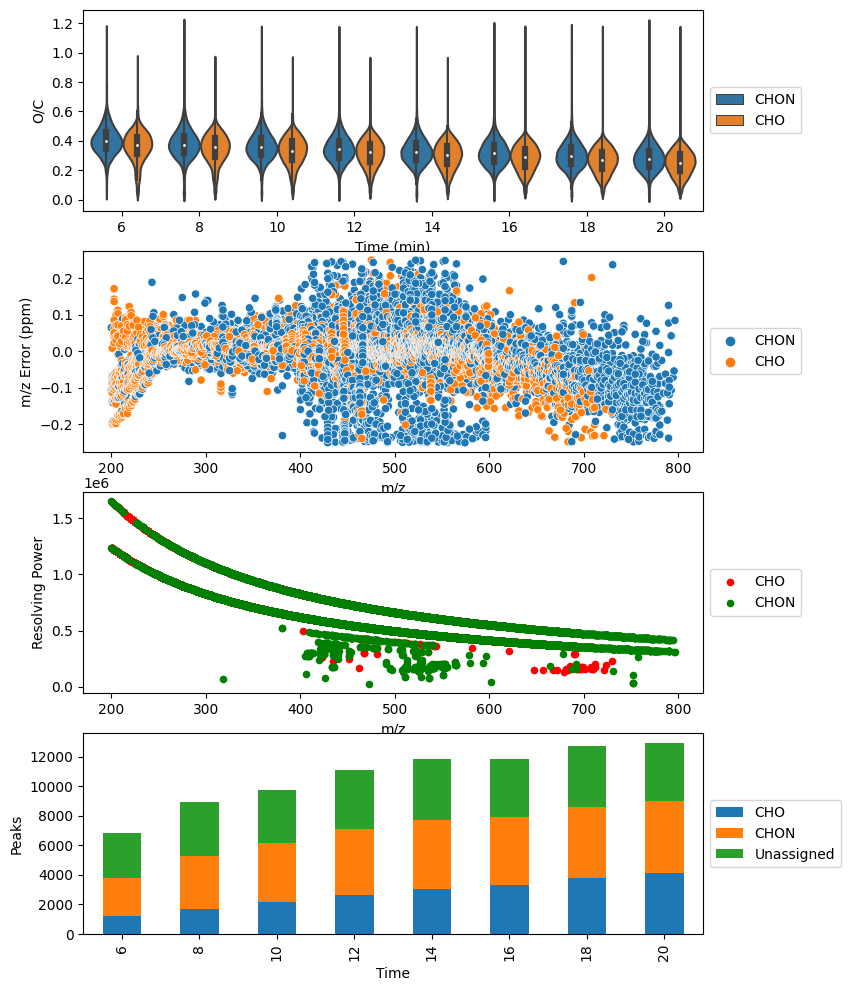

In [34]:
data.assess_all_results() ## why is it necessary to run this to get self.complete_results_df?

In [35]:
# add 'm/z window' and 'rep' columns

data_df = data.complete_results_df

data_df = add_mzwindow_col(data_df)

data_df = addRepCol(data_df)

print(data_df['m/z window'].unique())
print(data_df['Rep'].unique())
print(data_df['file'].unique())

20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
[1]
['400-600 m/z' '200-1200 m/z' '400-500 m/z' '500-600 m/z']
[1]
['20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw']


In [36]:
# save assignment results as pd dataframe and export as .csv 
data_df.to_csv("/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/spring-max600mz_22-12_6_Cu.csv")


In [38]:
#create subsets of assignments based m/z window

list100mz = []
list200mz = []
listfullzmz = [] 

for mzwindow in data_df['m/z window'].unique():

    r_df = data_df[data_df['m/z window'] == mzwindow]

    if (mzwindow == '400-600 m/z') or (mzwindow == '600-800 m/z'):
        list200mz.append(r_df)

    elif (mzwindow == '400-500 m/z') or (mzwindow == '500-600 m/z') or (mzwindow == '600-700 m/z') or (mzwindow == '700-800 m/z'):
        list100mz.append(r_df) 

    elif (mzwindow == '200-1200 m/z'):
        listfullzmz.append(r_df) 

mz100 = pd.concat(list100mz)
mz200 = pd.concat(list200mz)
mzfull = pd.concat(listfullzmz)


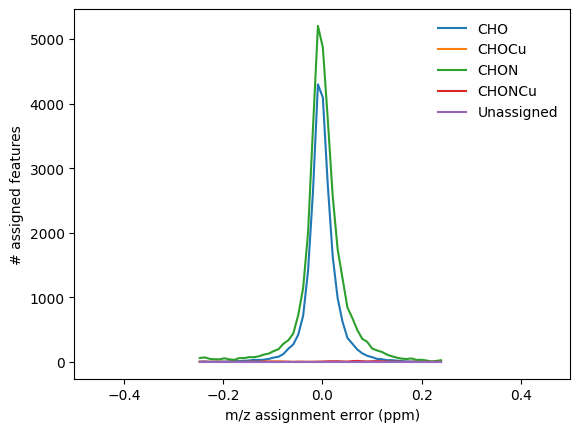

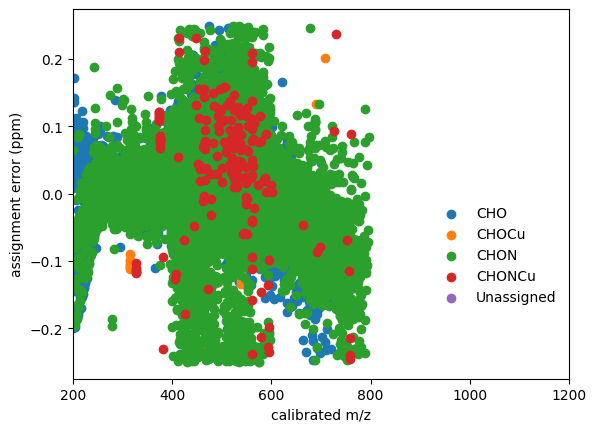

In [39]:
# plot assignment error distribution for full data set
pltMZerror(assignMolClass(data_df))

plt.show()

pltMZerror_pts(assignMolClass(data_df))

plt.show()

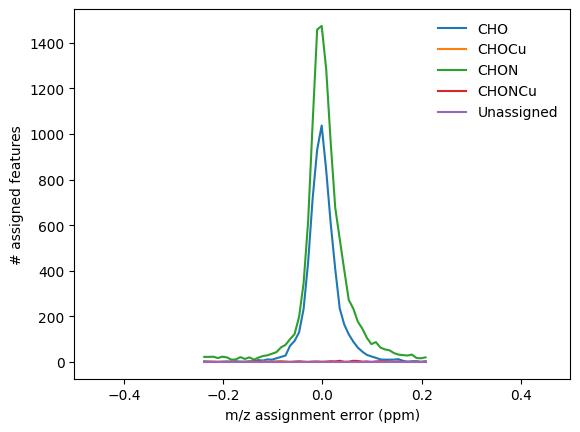

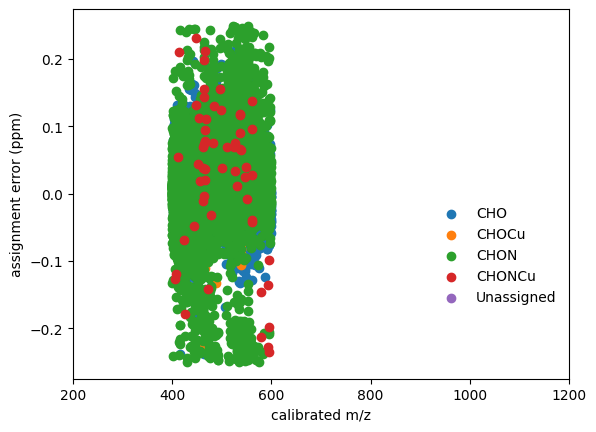

In [40]:
# plot assignment error dist for m/z 100 scans
pltMZerror(assignMolClass(mz100))

plt.show()

pltMZerror_pts(assignMolClass(mz100))

plt.show()

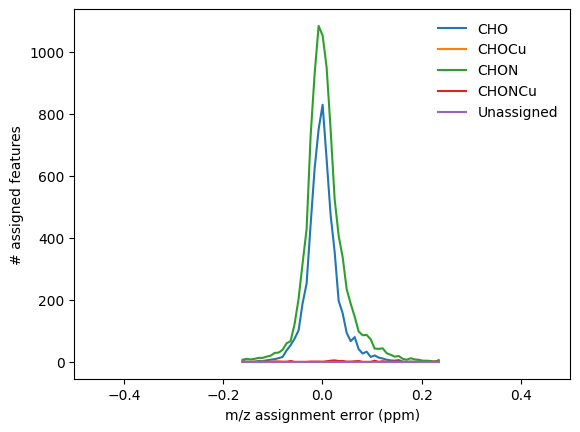

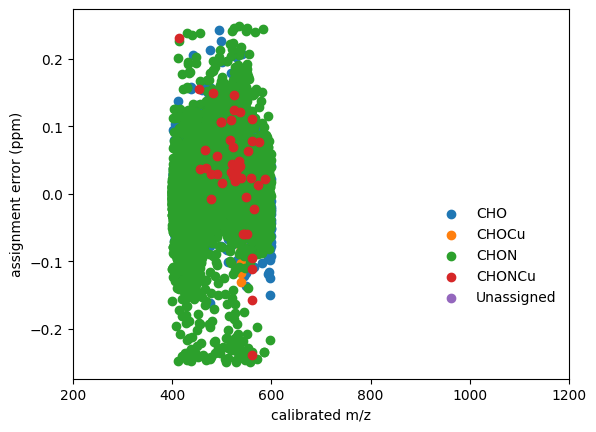

In [41]:
# plot assignment error dist for m/z 200 scans
pltMZerror(assignMolClass(mz200))

plt.show()

pltMZerror_pts(assignMolClass(mz200))

plt.show()

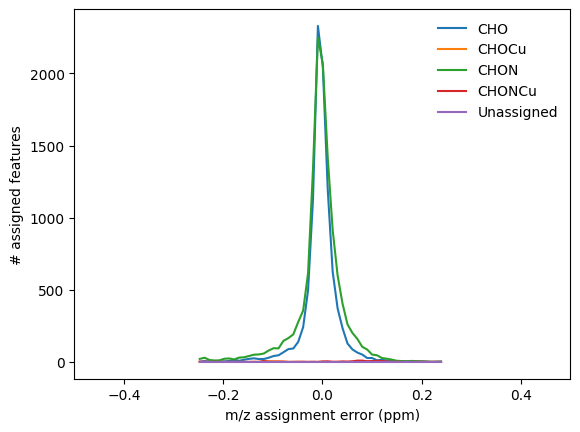

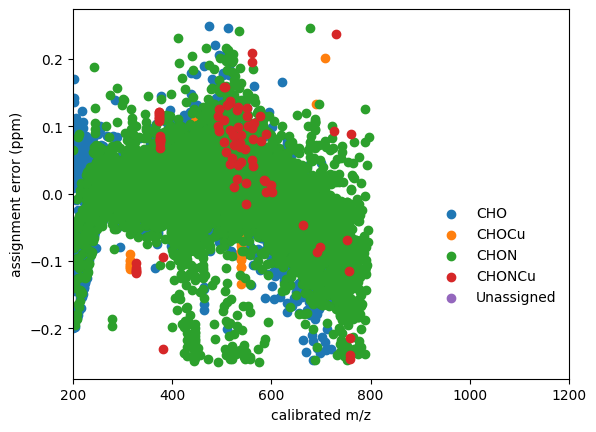

In [42]:
# plot assignment error dist for full m/z scans 
pltMZerror(assignMolClass(mzfull))

plt.show()

pltMZerror_pts(assignMolClass(mzfull))

plt.show()

In [44]:
assigned_100mz = mz100[~mz100['Molecular Formula'].isnull()]
assigned_200mz = mz200[~mz200['Molecular Formula'].isnull()]
assigned_fullmz = mzfull[~mzfull['Molecular Formula'].isnull()]

print('400-600 m/z, 100 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz100)[0],  np.shape(assigned_100mz)[0], np.shape(assigned_100mz)[0] / np.shape(mz100)[0] * 100))
print('400-600 m/z, 200 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz200)[0], np.shape(assigned_200mz)[0], np.shape(assigned_200mz)[0] / np.shape(mz200)[0] * 100))
print('200-800 m/z window (full scan): \n%s features total; %s assigned (%.1f%%)' %(np.shape(mzfull)[0],np.shape(assigned_fullmz)[0],  np.shape(assigned_fullmz)[0] / np.shape(mzfull)[0] * 100))

print('\n\n')

unique_100mz = getUniqueFeatures(assigned_100mz)
unique_200mz = getUniqueFeatures(assigned_200mz)
unique_fullmz = getUniqueFeatures(assigned_fullmz)


400-600 m/z, 100 m/z windowing: 
34154 features total; 20037 assigned (58.7%)
400-600 m/z, 200 m/z windowing: 
26468 features total; 16768 assigned (63.4%)
200-800 m/z window (full scan): 
40083 features total; 25181 assigned (62.8%)



total # results: 20037
# unique results: 19683
total # results: 16768
# unique results: 16768
total # results: 25181
# unique results: 24197


In [45]:
assigned_100mz_456 = assigned_100mz[(assigned_100mz['m/z']>=400)]
assigned_100mz_456 = assigned_100mz_456[(assigned_100mz_456['m/z']<=600)]

assigned_200mz_456 = assigned_200mz[(assigned_200mz['m/z']>=400)]
assigned_200mz_456 = assigned_200mz_456[(assigned_200mz_456['m/z']<=600)]

assigned_fullmz_456 = assigned_fullmz[(assigned_fullmz['m/z']>=400)]
assigned_fullmz_456 = assigned_fullmz_456[(assigned_fullmz_456['m/z']<=600)]

mz100_456 = mz100[(mz100['m/z']>=400)]
mz100_456 = mz100_456[(mz100_456['m/z']<=600)]

mz200_456 = mz200[(mz200['m/z']>=400)]
mz200_456 = mz200_456[(mz200_456['m/z']<=600)]

mzfull_456 = mzfull[(mzfull['m/z']>=400)]
mzfull_456 = mzfull_456[(mzfull_456['m/z']<=600)]

print('400-600 m/z, 100 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz100_456)[0],  np.shape(assigned_100mz_456)[0], np.shape(assigned_100mz_456)[0] / np.shape(mz100_456)[0] * 100))
print('\n400-600 m/z, 200 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz200_456)[0], np.shape(assigned_200mz_456)[0], np.shape(assigned_200mz_456)[0] / np.shape(mz200_456)[0] * 100))
print('\n400-600 m/z, full window: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mzfull_456)[0],np.shape(assigned_fullmz_456)[0],  np.shape(assigned_fullmz_456)[0] / np.shape(mzfull_456)[0] * 100))



400-600 m/z, 100 m/z windowing: 
34154 features total
20037 assigned (58.7%)

400-600 m/z, 200 m/z windowing: 
26468 features total
16768 assigned (63.4%)

400-600 m/z, full window: 
20098 features total
12312 assigned (61.3%)


In [46]:

unique_100mz_456 = getUniqueFeatures(assigned_100mz_456)
unique_200mz_456 = getUniqueFeatures(assigned_200mz_456)
unique_fullmz_456 = getUniqueFeatures(assigned_fullmz_456)

total # results: 20037
# unique results: 19683
total # results: 16768
# unique results: 16768
total # results: 12312
# unique results: 12213


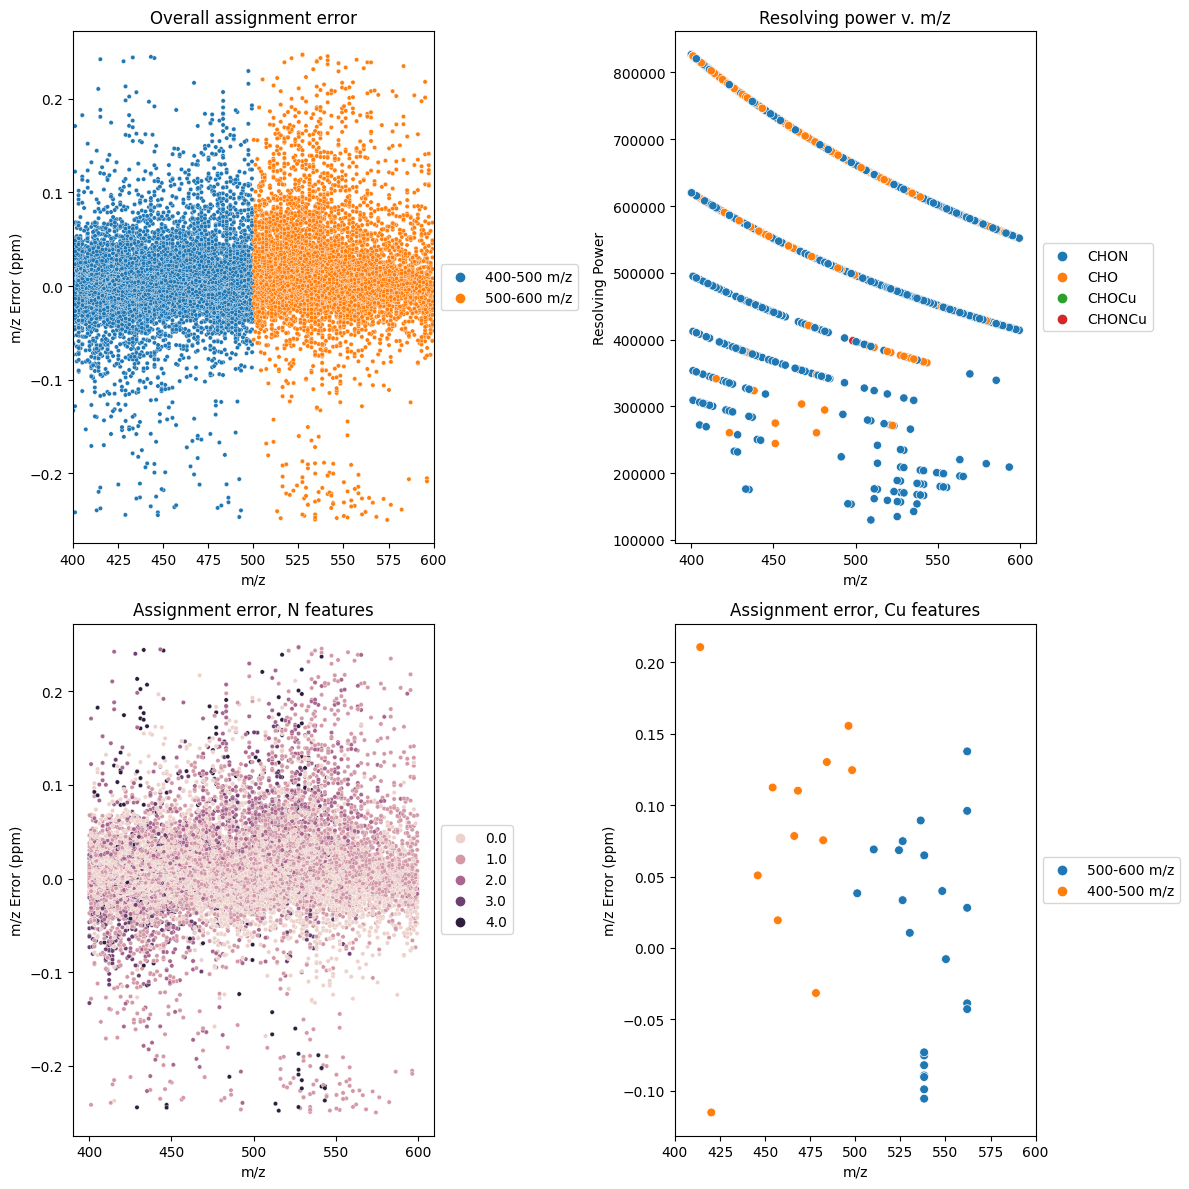

['20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw']


In [49]:
# 100 m/z window, error plots with blanks removed 
mask = ~unique_100mz_456['file'].str.contains('qh2o', case=False, na=False)
unique_100mz_nb=unique_100mz_456[mask]
df = assignMolClass(unique_100mz_nb)

fig = plotUnique(df,ps=10)
plt.tight_layout()
plt.show()
print(unique_100mz_nb['file'].unique())

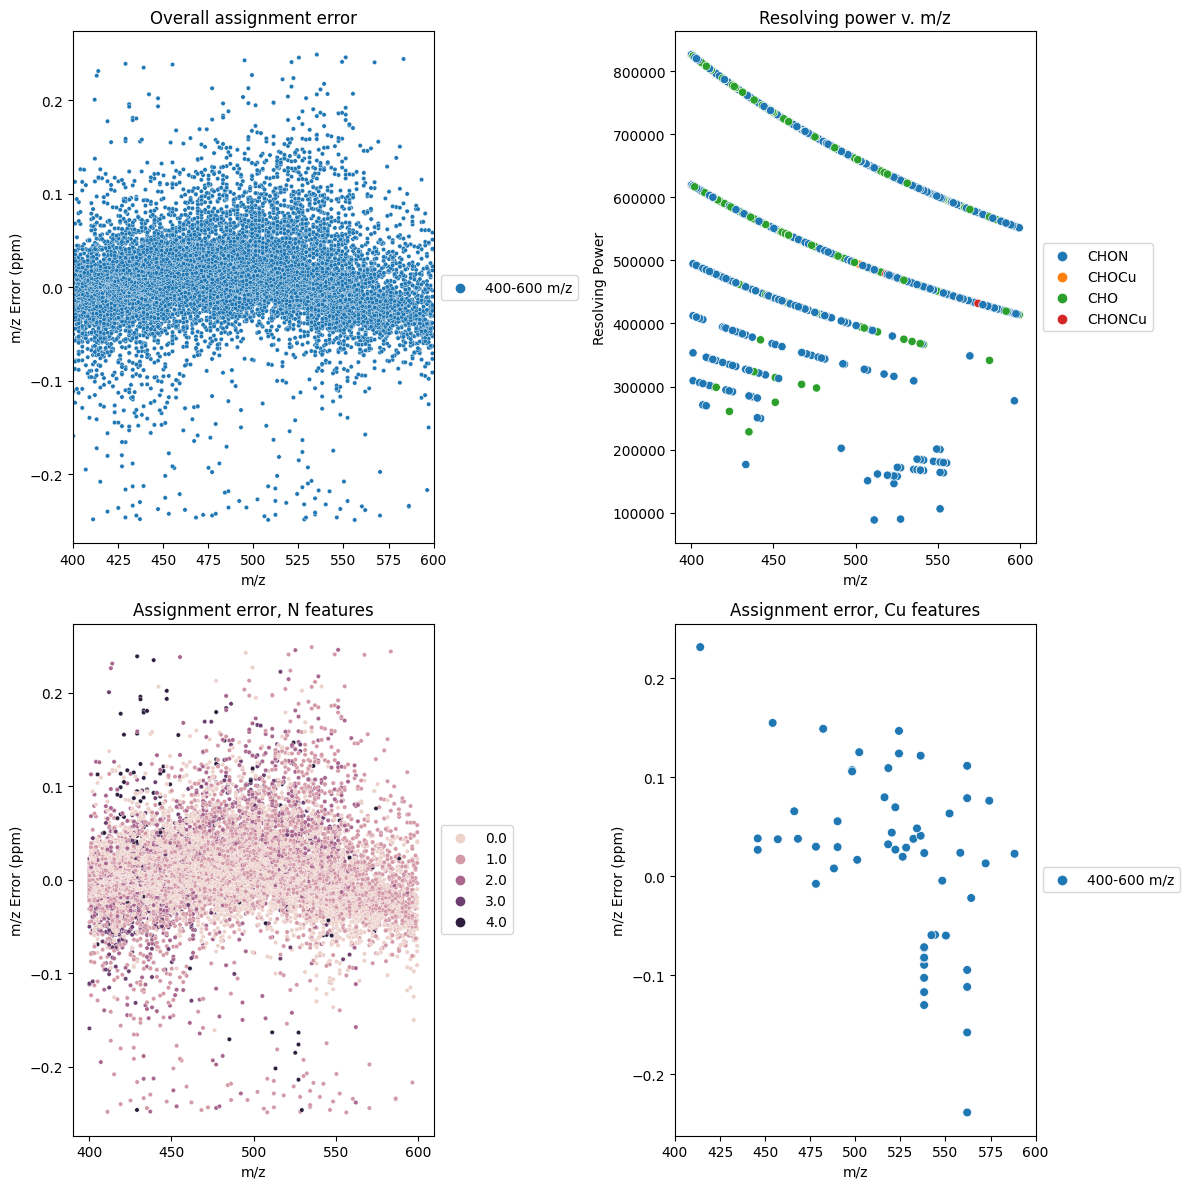

['20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw']


In [50]:
# 200 m/z window, error plots with blanks removed 

mask = ~unique_200mz_456['file'].str.contains('qh2o', case=False, na=False)
unique_200mz_nb=unique_200mz_456[mask]


fig = plotUnique(assignMolClass(unique_200mz_nb),ps=10)
plt.tight_layout()
plt.show()
plt.close('all')

print(unique_200mz_nb['file'].unique())

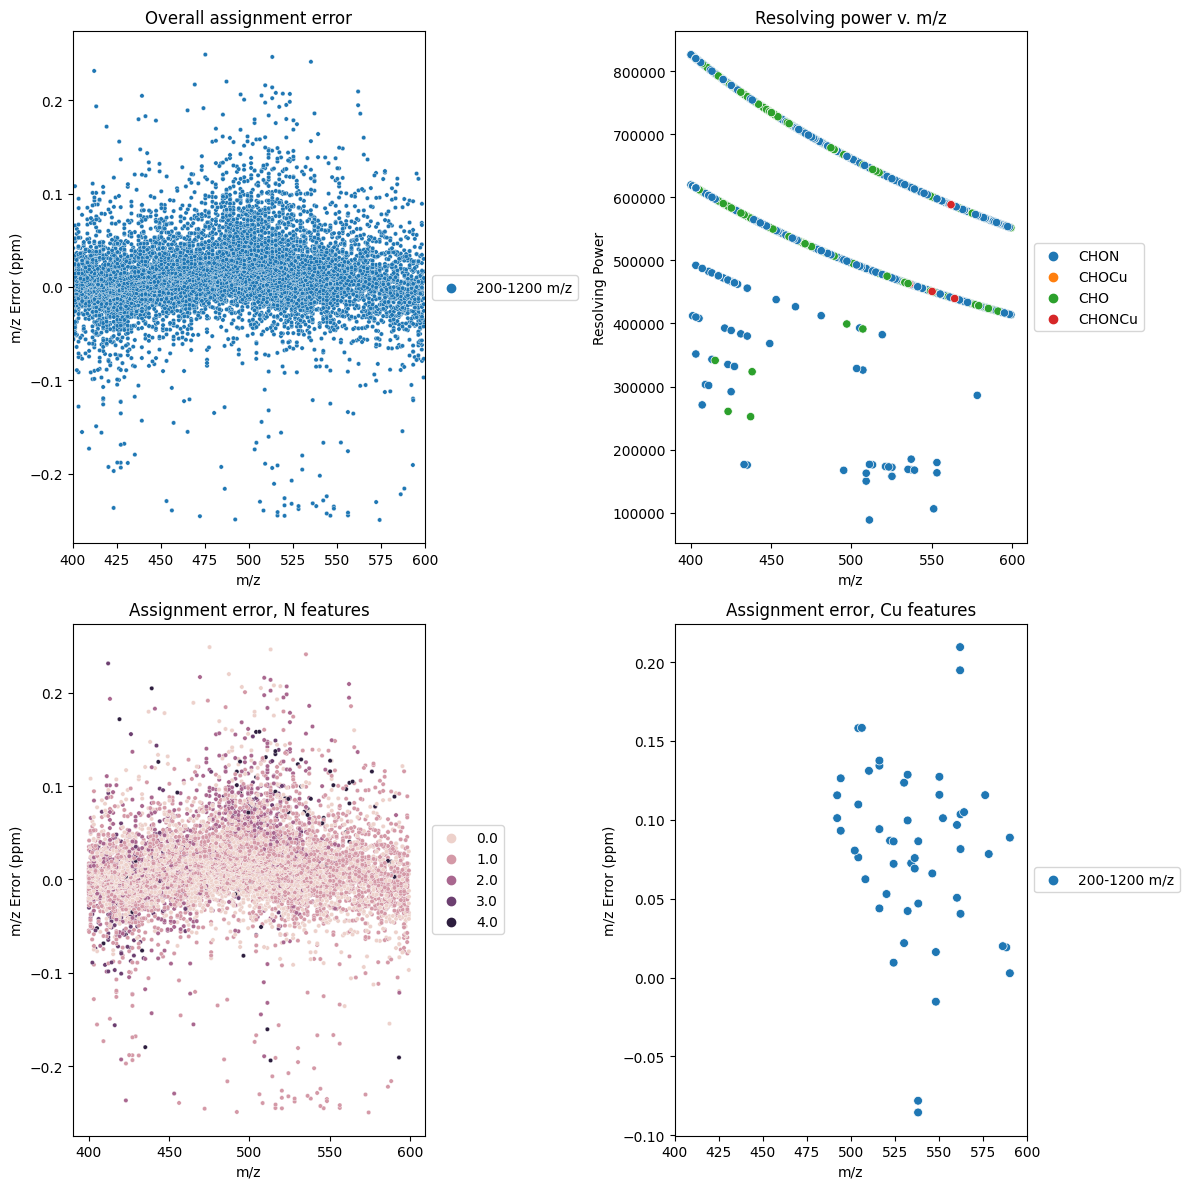

['20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw']


In [51]:
# full m/z window, error plots with blanks removed 

mask = ~unique_fullmz_456['file'].str.contains('qh2o', case=False, na=False)
unique_fullmz_nb=unique_fullmz_456[mask]


fig = plotUnique(assignMolClass(unique_fullmz_nb),ps=10)
plt.tight_layout()
plt.show()
plt.close('all')

print(unique_fullmz_nb['file'].unique())

In [53]:
# create 200 m/z blank files from 100 m/z blank files (did not collect 200 m/z blank files)

blank_files = [f for f in data._raw_filelist if 'qh2o' in f]

blank_data = []

for f in blank_files:

    if 'fullmz' not in f:
        
        temp = data_df[data_df['file'] == f] 

        blank_data.append(temp)

blanks_df = pd.concat(blank_data)

rep1_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
rep1_temp = rep1_temp[rep1_temp['m/z'] <= 600]
rep1_temp['file'] = 'mz200_400_600_blnk'
rep1_temp['m/z window'] = '400-600 m/z'

blanks_df = pd.concat([blanks_df,rep1_temp])

#rep1_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
#rep1_temp = rep1_temp[rep1_temp['m/z'] >= 600]
#rep1_temp['file'] = 'mz200_600_800_blnk'
#rep1_temp['m/z window'] = '600-800 m/z'

blanks_df = pd.concat([blanks_df,rep1_temp])


rep2_temp = blanks_df[blanks_df['file'].str.contains('rep2')]
rep2_temp = rep2_temp[rep2_temp['m/z'] <= 600]
rep2_temp['file'] = 'mz200_400_600_blnk_rep2'
rep2_temp['m/z window'] = '400-600 m/z'

blanks_df = pd.concat([blanks_df,rep2_temp])

#rep2_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
#rep2_temp = rep2_temp[rep2_temp['m/z'] >= 600]
#rep2_temp['file'] = 'mz200_600_800_blnk_rep2'
#rep2_temp['m/z window'] = '600-800 m/z'

blanks_df = pd.concat([blanks_df,rep2_temp])

print(blanks_df['file'].unique())

print(blanks_df['m/z window'].unique())



['20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw' 'mz200_400_600_blnk']
['400-500 m/z' '500-600 m/z' '400-600 m/z']


In [54]:
# add 200 m/z blank data to master df

mz200_blanks = blanks_df[blanks_df['m/z window'] == '400-600 m/z']
data_df = pd.concat([data_df, mz200_blanks])

for f in data_df['file'].unique():
    print(f)




20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
mz200_400_600_blnk


In [55]:
# add fullmz blanks to blanks df
blanks_df = pd.concat([blanks_df, data_df[data_df['file'] =='20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw' ]])
blanks_df = pd.concat([blanks_df, data_df[data_df['file'] =='20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw' ]])

print(blanks_df['m/z window'].unique())

['400-500 m/z' '500-600 m/z' '400-600 m/z' '200-1200 m/z']


In [56]:
# add column with blank file identity to use in blank subtraction
df_backup = data_df
df_backup.to_csv("/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/spring-max600mz_backup.csv")

data_df['blank file'] = data_df.index

for window in data_df['m/z window'].unique():

    temp1 = data_df[data_df['m/z window'] == window] # all features collected in given m/z window       
    btemp1 = blanks_df[blanks_df['m/z window'] == window] # all blank feautres collected in same m/z window

    for r in temp1['Rep'].unique():
        temp2 = temp1[temp1['Rep'] == r]
        btemp2 = btemp1[btemp1['Rep'] == r]


        temp2['blank file'] = btemp2['file'].iloc[0]

        data_df[(data_df['m/z window'] == window) & (data_df['Rep'] == r)]  = temp2


print(data_df['blank file'].unique())

['mz200_400_600_blnk' '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw']


In [57]:
def blankSubtract(df, blnkthresh = 0.9):
    
    holder = []
    for file in df['file'].unique():
        
        #if file == 
        sub = df[df['file'] == file]

        blkf = sub['blank file'].iloc[0]


        sub[sub[file]== np.nan] = 0

        nom = sub[file]
        den = sub[blkf]

        nom = nom.replace(np.nan,0)
        den = den.replace(np.nan,1)

        if file != blkf:
            nom = nom
        elif file == blkf:
            nom = nom * (blnkthresh*0.8)

        sub['blank subtract'] = nom/den
        holder.append(sub)
    df_end = pd.concat(holder)
    df_end = df_end[df_end['blank subtract'] > blnkthresh]
    return df_end

In [58]:
df_unique = getUniqueFeatures(data_df)


total # results: 108399
# unique results: 32303


In [59]:
df_bs = blankSubtract(df_unique, blnkthresh=0.3)


(28100, 45)


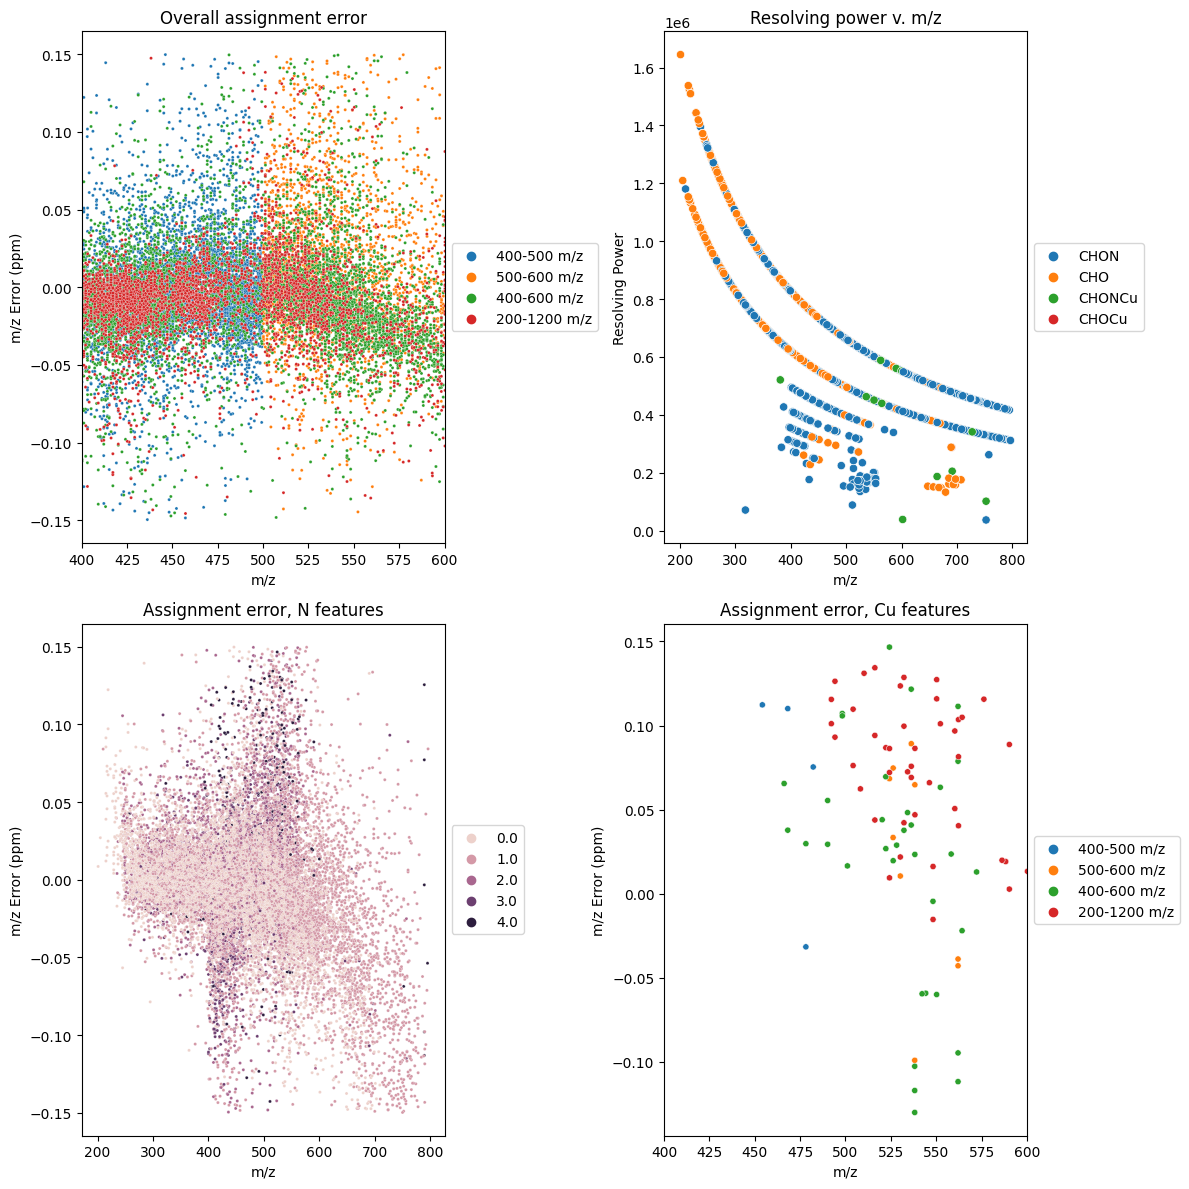

In [60]:
temp = df_bs[abs(df_bs['m/z Error (ppm)'])<0.15]
print(np.shape(temp))
fig = plotUnique(assignMolClass(pd.concat([temp[temp['m/z window']== '400-500 m/z'], temp[temp['m/z window']=='500-600 m/z'], temp[temp['m/z window']=='400-600 m/z'], temp[temp['m/z window']=='200-1200 m/z']])),ps=5)

plt.tight_layout()
plt.show()
plt.close('all')

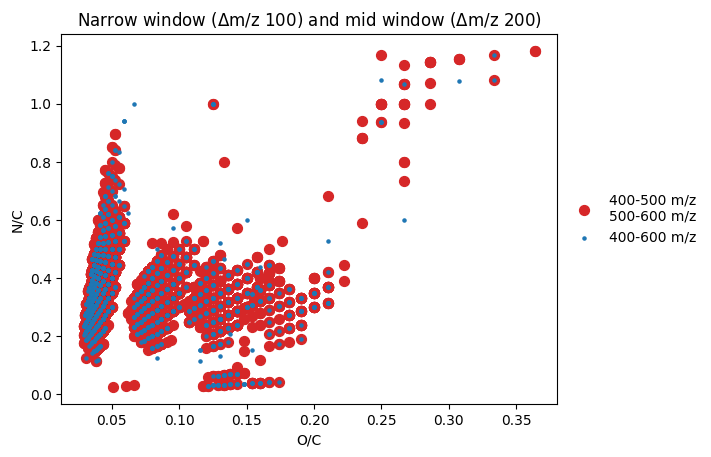

In [61]:
mz100_bs = df_bs[(df_bs['m/z window'] == '400-500 m/z') | (df_bs['m/z window'] == '500-600 m/z')]

mz200_bs = df_bs[(df_bs['m/z window'] == '400-600 m/z')]

mzfull_bs = df_bs[(df_bs['m/z window'] == '200-1200 m/z')]
mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]

df = mz100_bs
df2 = mz200_bs
df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',s=50,label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#sns.scatterplot(x='N/C',y='O/C', hue='m/z', data=df, ax=ax,s=50)
ax.scatter(x=df2['N/C'],y=df2['O/C'],c='C0',s=5,label='400-600 m/z') #s=df2['S/N'],
#ax.scatter(x=df3['N/C'],y=df3['O/C'],c='C5',label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and mid window ($\Delta$m/z 200)')
plt.show()


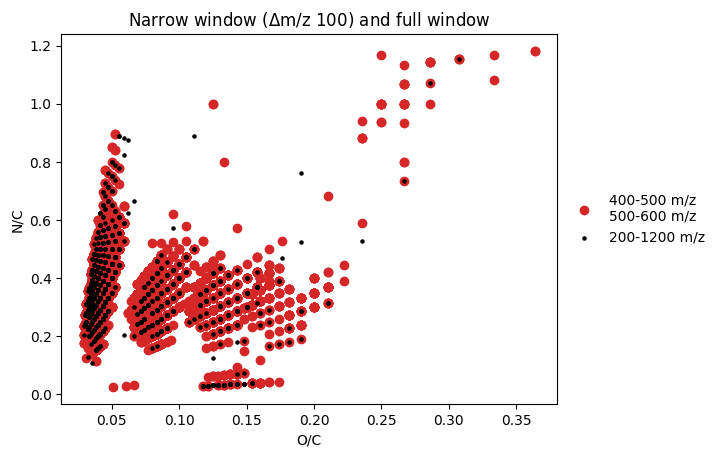

In [62]:
mz100_bs = df_bs[(df_bs['m/z window'] == '400-500 m/z') | (df_bs['m/z window'] == '500-600 m/z')]

mz200_bs = df_bs[(df_bs['m/z window'] == '400-600 m/z')]

mzfull_bs = df_bs[(df_bs['m/z window'] == '200-1200 m/z')]
mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]

df = mz100_bs
df2 = mz200_bs
df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#ax.scatter(x=df2['N/C'],y=df2['O/C'],c='black',s=5,label='400-600 m/z') #s=df2['S/N'],
ax.scatter(x=df3['N/C'],y=df3['O/C'],c='black',s=5,label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and full window')
plt.show()


In [63]:
temp = df_bs[df_bs['m/z'] >= 400]
temp = temp[temp['m/z']<=600]

temp['m/z Window Size'] = temp.Index

for i in range(len(temp['m/z window'])):

    w = temp['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '1000 m/z'

In [64]:
mz100_contains_cu = mz100_bs[(mz100_bs['Cu'] == 1) ]
print(np.shape(mz100_contains_cu))
mz100_cu_limited_err = mz100_contains_cu[abs(mz100_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mz100_cu_limited_err))

mz200_contains_cu = mz200_bs[(mz200_bs['Cu'] == 1) ]
print(np.shape(mz200_contains_cu))
mz200_cu_limited_err = mz200_contains_cu[abs(mz200_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mz200_cu_limited_err))

mzfull_contains_cu = mzfull_bs[(mzfull_bs['Cu'] == 1)]
print(np.shape(mzfull_contains_cu))
mzfull_cu_limited_err = mzfull_contains_cu[abs(mzfull_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mzfull_cu_limited_err))


(59, 45)
(58, 45)
(98, 45)
(95, 45)
(73, 45)
(72, 45)


In [65]:
temp = temp[temp['Cu'] == 1]

temp['overlap'] = temp.Index

for i in range(len(temp['Molecular Formula'])):

    mf = temp['Molecular Formula'].iloc[i]

    if (mf not in mzfull_contains_cu['Molecular Formula'].values) and (mf not in mz200_contains_cu['Molecular Formula'].values):
        temp['overlap'].iloc[i] = 'n'

    elif (mf in mzfull_contains_cu['Molecular Formula'].values) and (mf not in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nw'

    elif (mf not in mzfull_contains_cu['Molecular Formula'].values) and (mf in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nm'

    elif (mf in mzfull_contains_cu['Molecular Formula'].values) and (mf in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nmw'



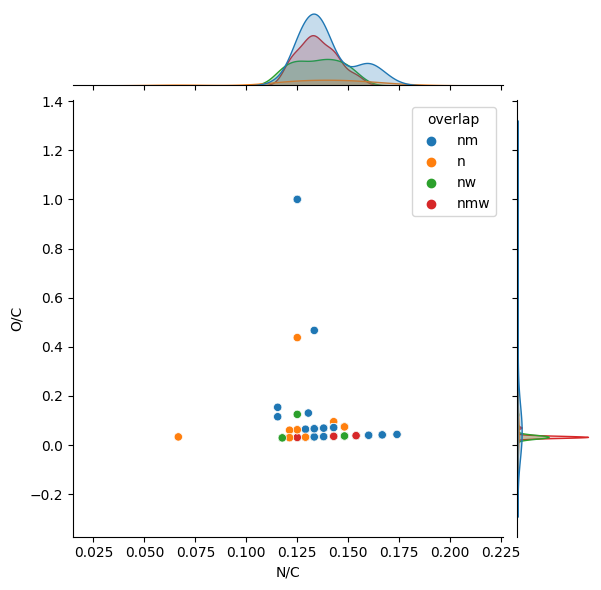

In [66]:
sns.jointplot(data=temp, x='N/C',y='O/C', hue='overlap')

In [67]:
print(np.shape(mzfull_cu_limited_err))
print(np.shape(mz100_cu_limited_err))

combo = pd.concat([mz100_cu_limited_err, mzfull_cu_limited_err])

combo['m/z Window Size'] = combo.Index

for i in range(len(combo['m/z window'])):

    w = combo['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '1000 m/z'

combo['m/z Window Size'].unique()

(72, 45)
(58, 45)


array(['100 m/z', '1000 m/z'], dtype=object)

In [68]:
mz100_cu_limited_err.columns

Index(['Index', 'm/z', 'Calibrated m/z', 'Calculated m/z', 'Peak Height',
       'Peak Area', 'Resolving Power', 'S/N', 'Ion Charge', 'm/z Error (ppm)',
       'm/z Error Score', 'Isotopologue Similarity', 'Confidence Score', 'DBE',
       'H/C', 'O/C', 'Heteroatom Class', 'Ion Type', 'Is Isotopologue',
       'Mono Isotopic Index', 'Molecular Formula', 'C', 'H', 'O', 'N', '13C',
       'Cu', 'Time', '18O', 'file', '65Cu', '15N', 'm/z window', 'Rep',
       'blank file', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw',
       '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw', 'mz200_400_600_blnk',
       'N/C', 'blank subtract'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


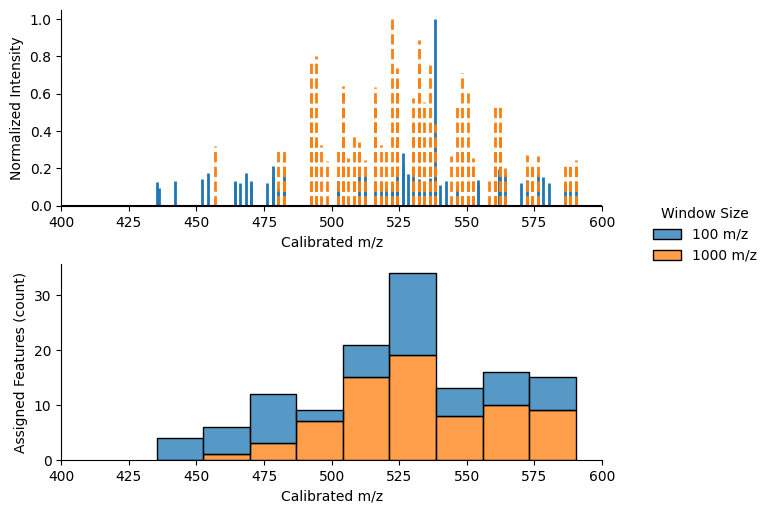

In [69]:
import matplotlib.gridspec as gridspec

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.02)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0], hspace = .05)

d1=normMS(mz100_cu_limited_err,mz100_cu_limited_err)
d2=normMS(mzfull_cu_limited_err,mzfull_cu_limited_err)

ax1_b = plt.subplot(gs1[0])
ax1_b = plot_ms(df1=d1,  df2=d2, start_mz=400, end_mz=600,ax_ms=ax1_b, norm=True)

sns.despine(ax=ax1_b)

ax1_b.set_ylim(bottom=0)





ax2 = plt.subplot(gs2[0])

sns.despine(ax=ax2)

sns.histplot(combo, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2)
ax2.set_ylabel('Assigned Features (count)')
ax2.set_xlim(400,600)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

plt.show()

In [ ]:
inds = np.where(np.asarray(mz100_EICdic[mf].time)<28)

np.asarray(mz100_EICdic[mf].time)[inds]

In [70]:
#data.master_data_holder['20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw'] #[file]={'parser': parser}
mz100_cu_limited_err = mz100_contains_cu[abs(mz100_contains_cu['m/z Error (ppm)']) < 0.25]
mz100_EICdic = {}
for mz,file,mf in zip(mz100_cu_limited_err['m/z'],mz100_cu_limited_err['file'],mz100_cu_limited_err['Molecular Formula']):
    
    parser = data.master_data_holder[file]['parser']    
 
    EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
    mz100_EICdic[mf]=EIC[0][mz]
    #mz100_EICdic[mz]={'eic':EIC[0][mz],'formula':mf}


In [71]:
mzfull_cu_limited_err = mzfull_contains_cu[abs(mzfull_contains_cu['m/z Error (ppm)']) < 0.25]
fullmz_EICdic = {}
for mz,file,mf in zip(mzfull_cu_limited_err['m/z'],mzfull_cu_limited_err['file'],mzfull_cu_limited_err['Molecular Formula']):
    
    parser = data.master_data_holder[file]['parser']
 
    EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
    fullmz_EICdic[mf]=EIC[0][mz]

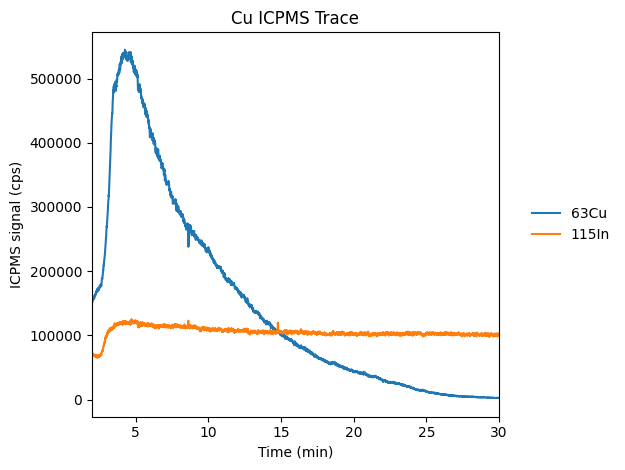

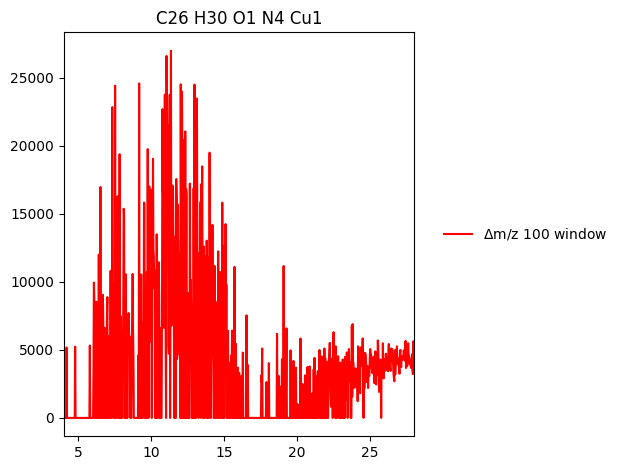

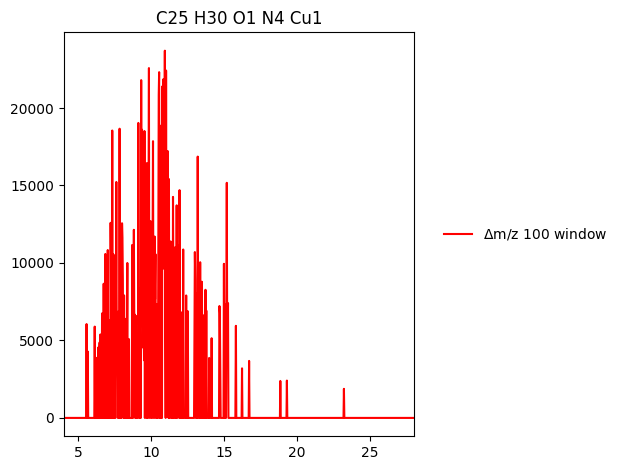

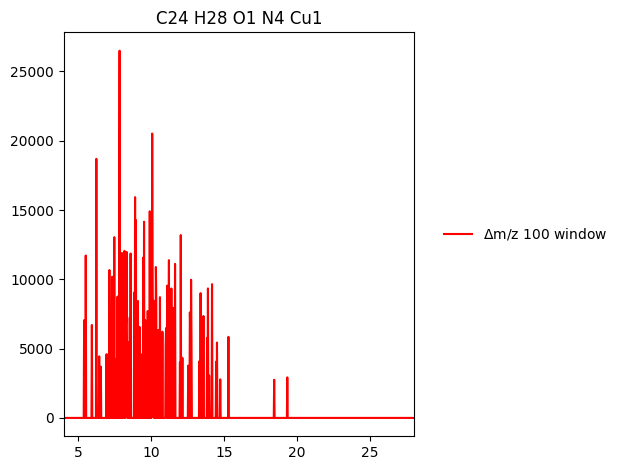

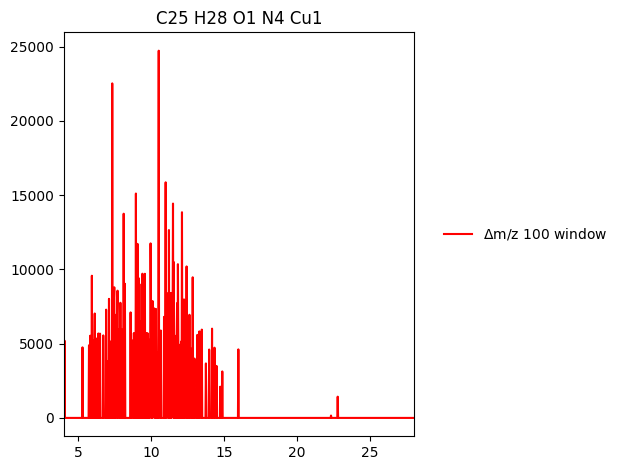

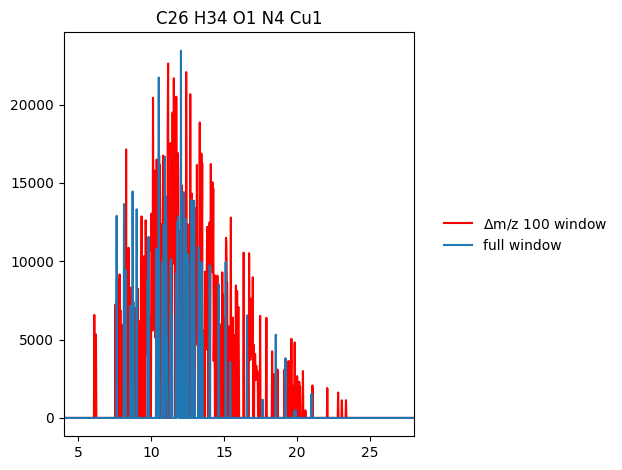

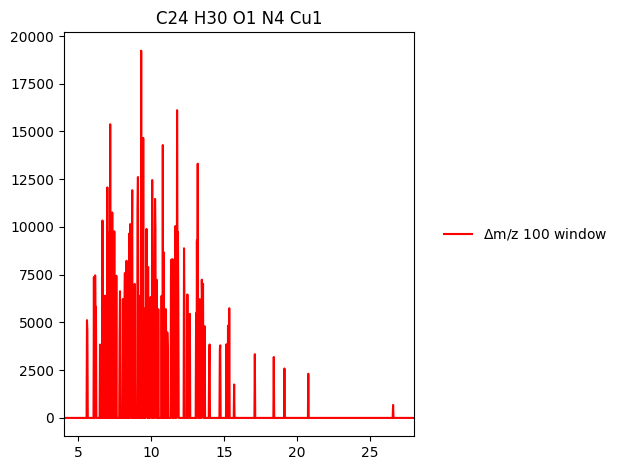

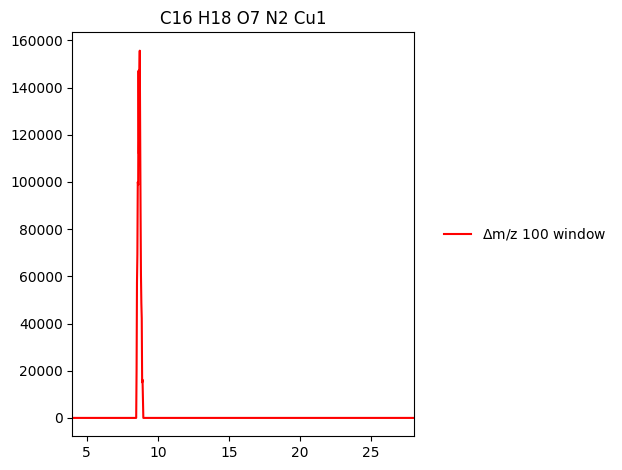

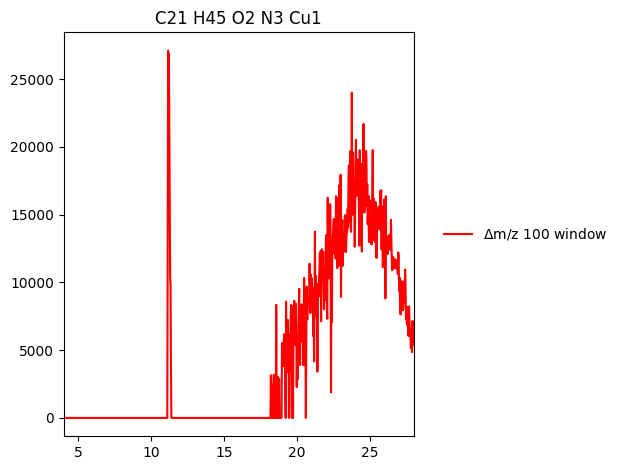

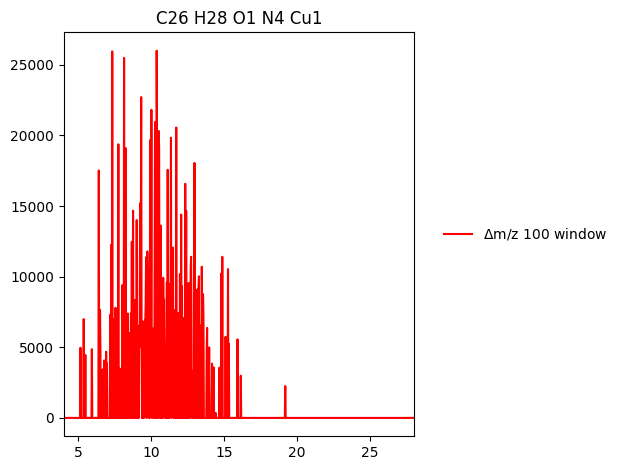

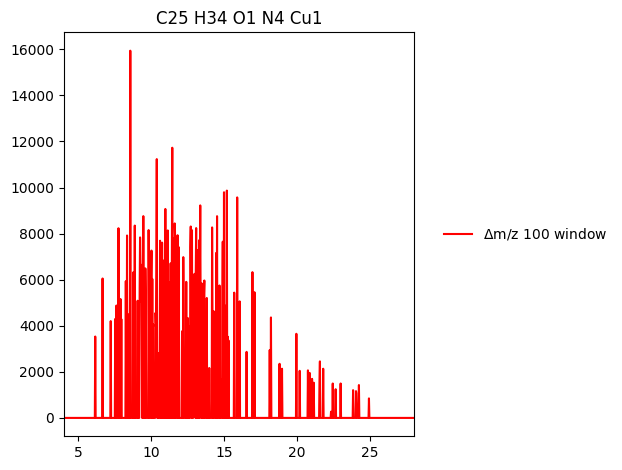

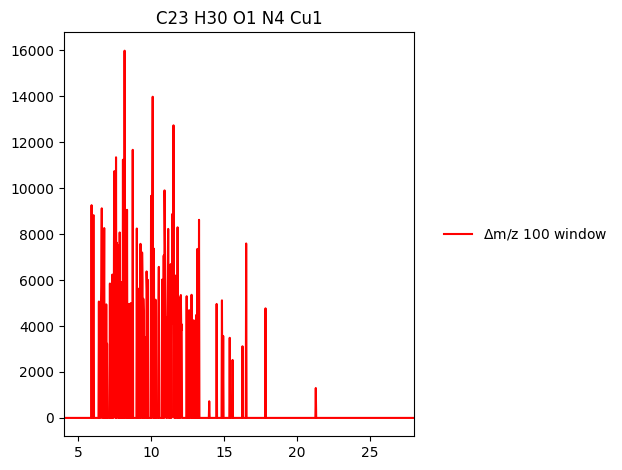

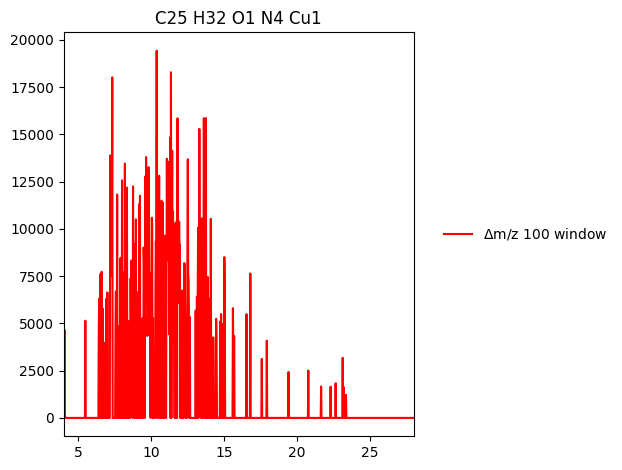

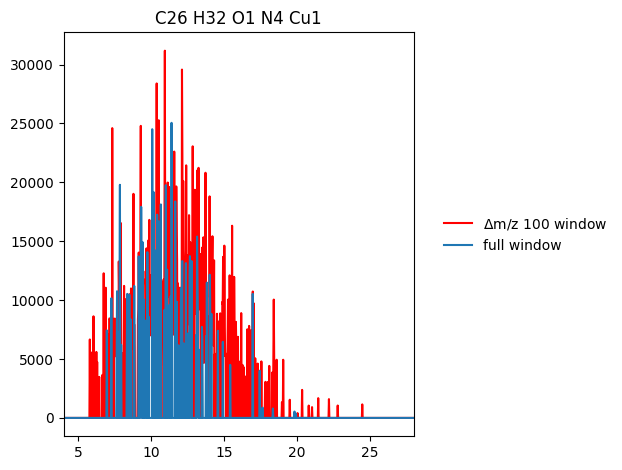

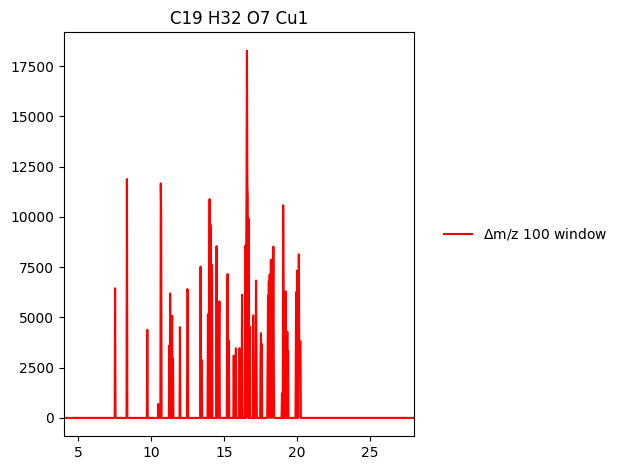

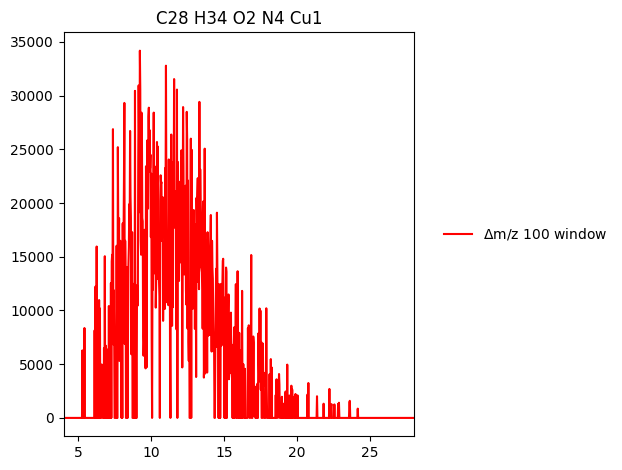

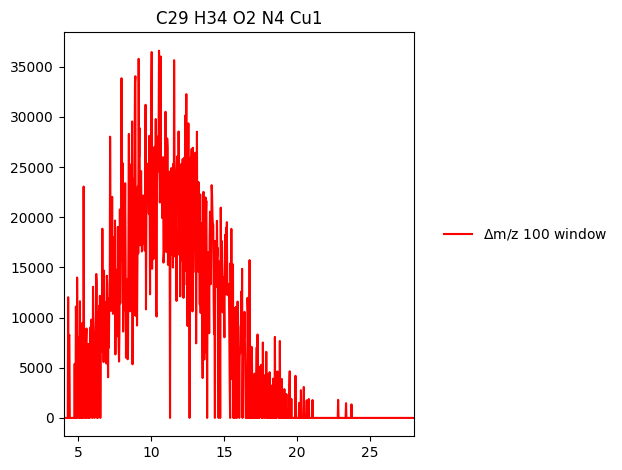

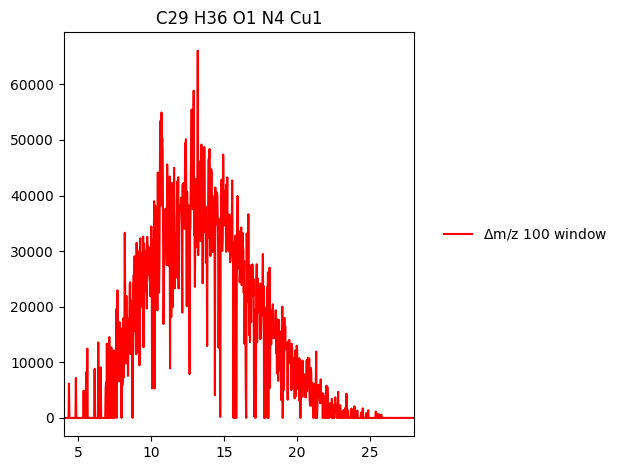

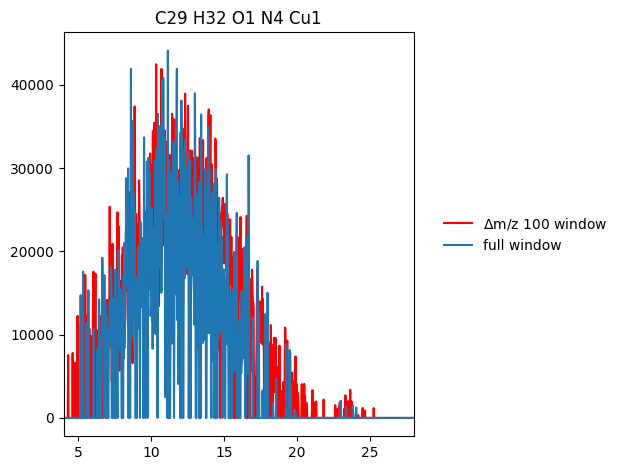

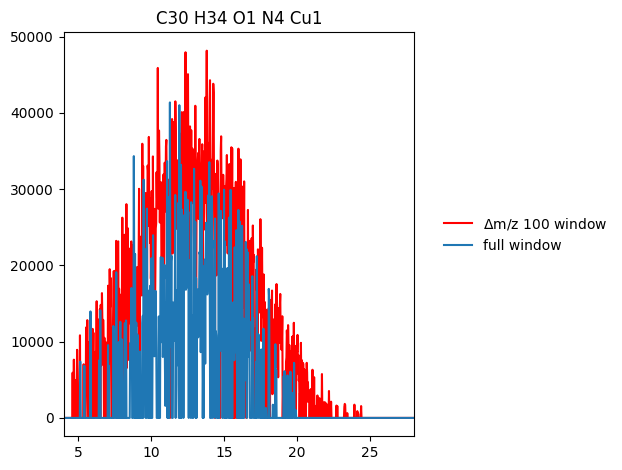

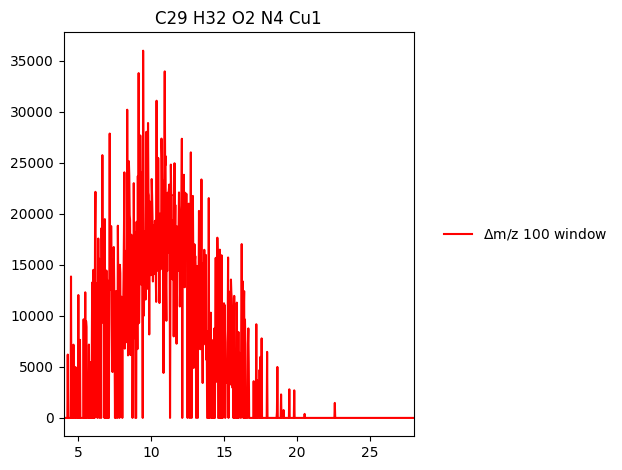

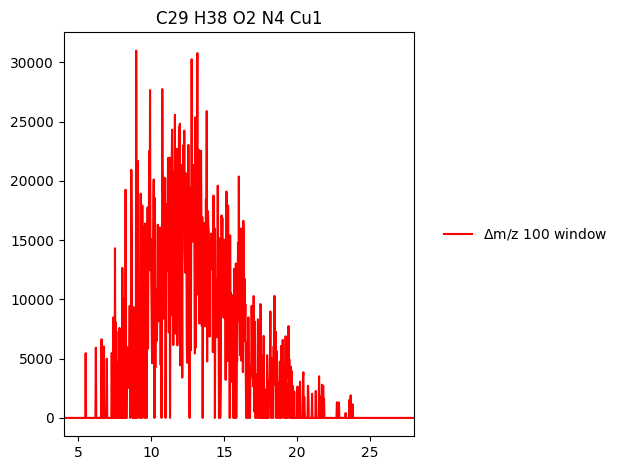

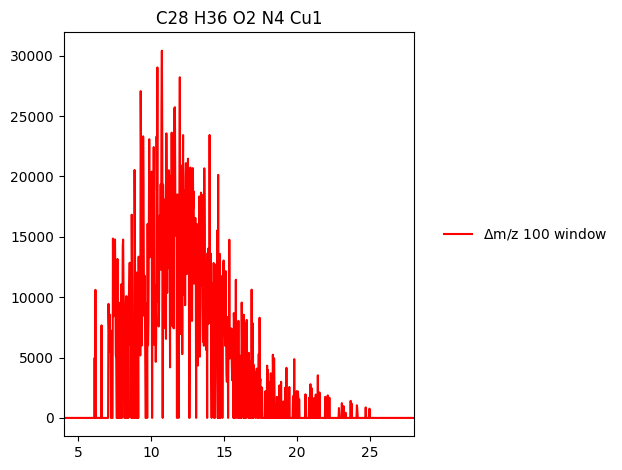

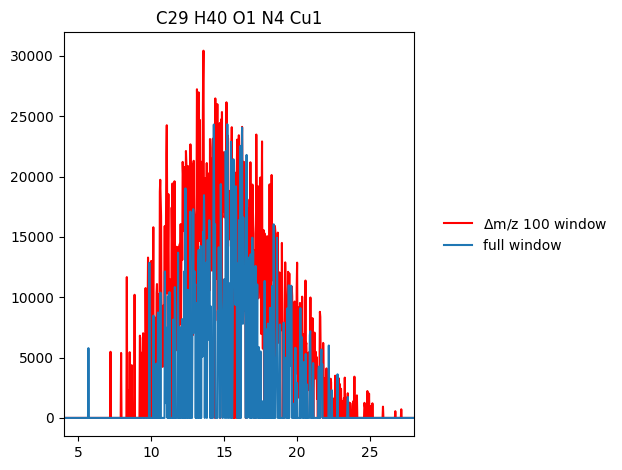

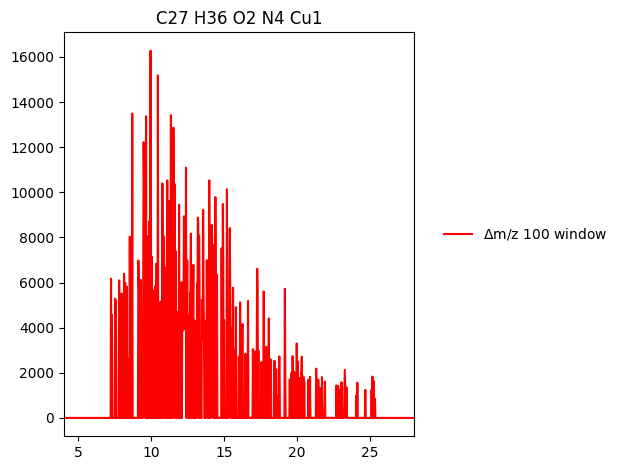

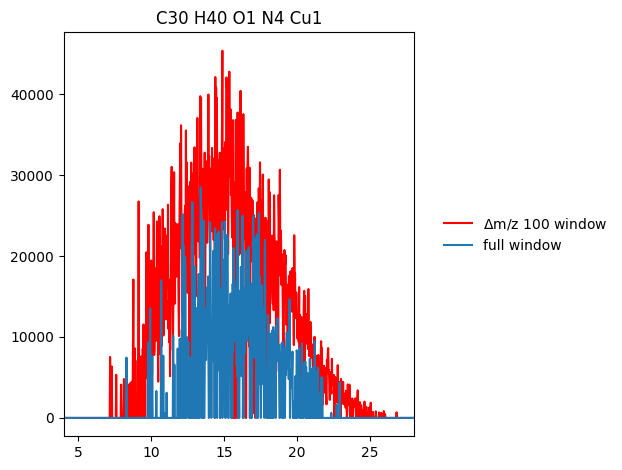

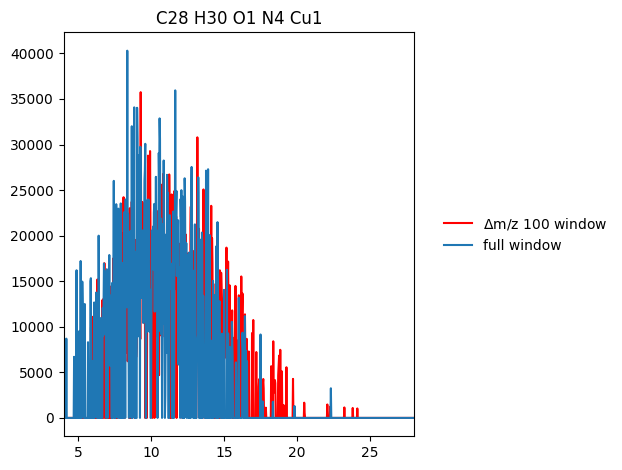

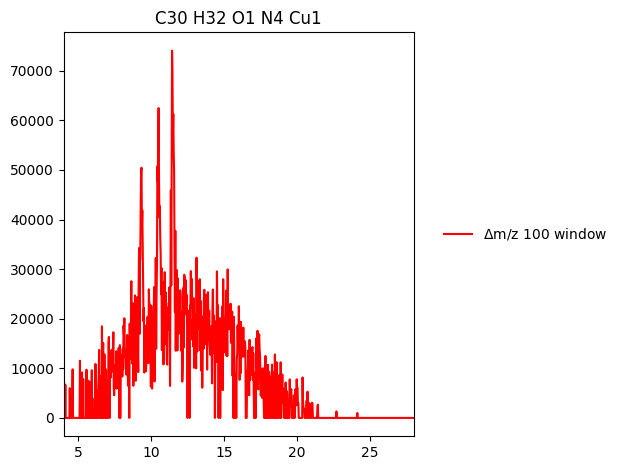

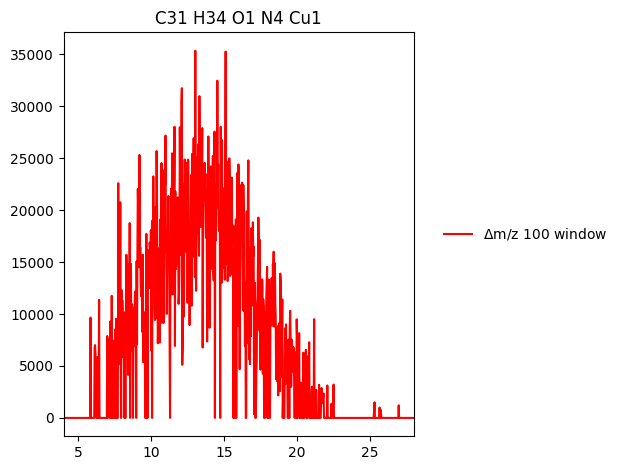

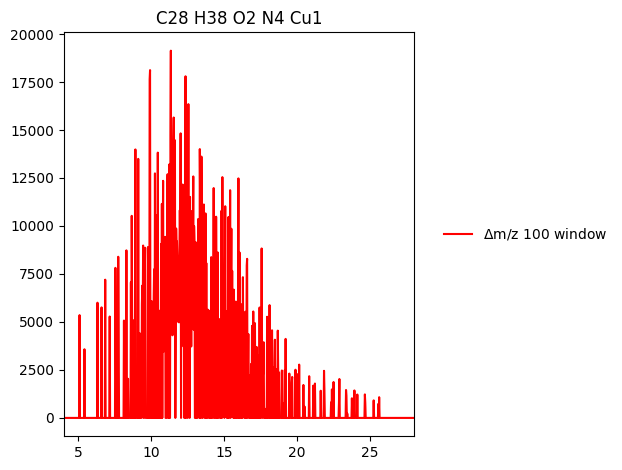

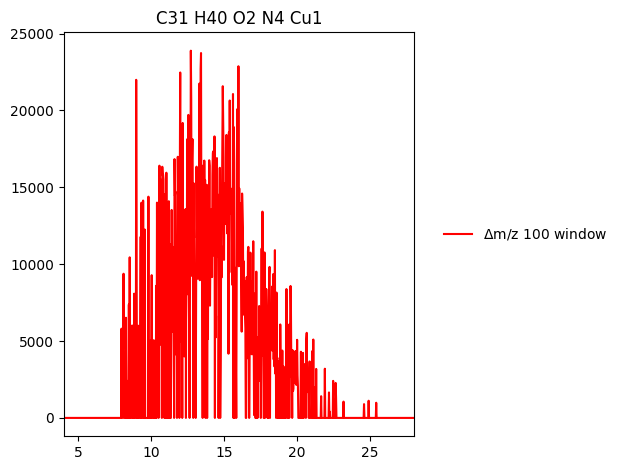

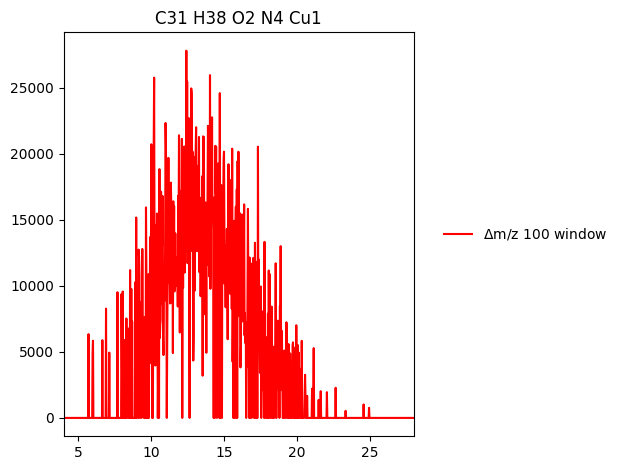

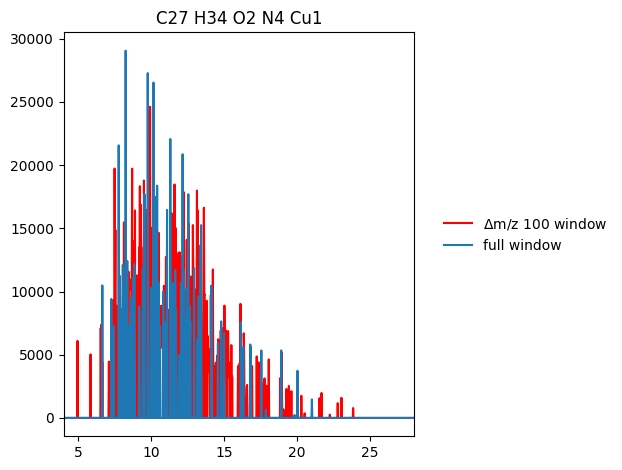

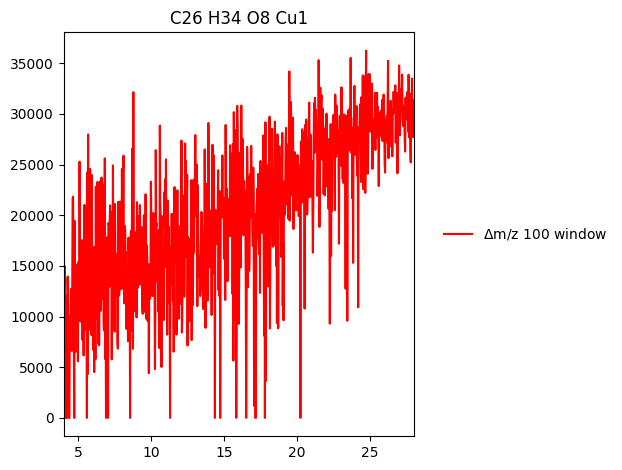

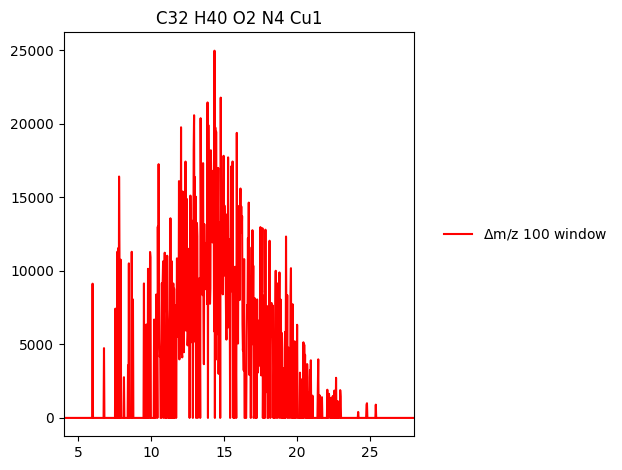

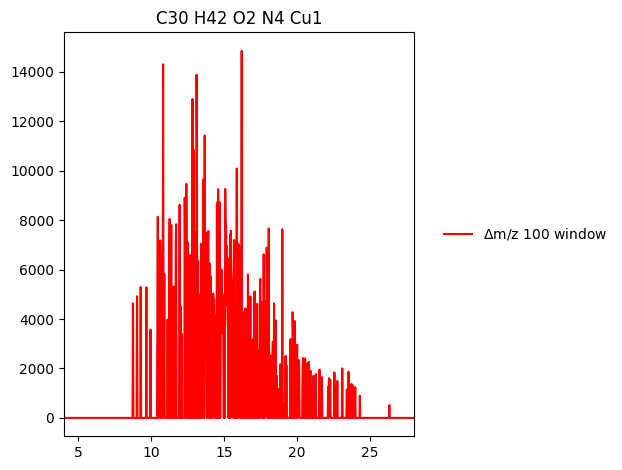

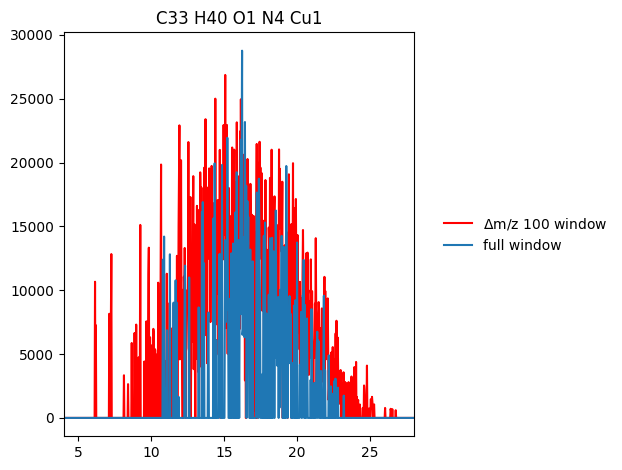

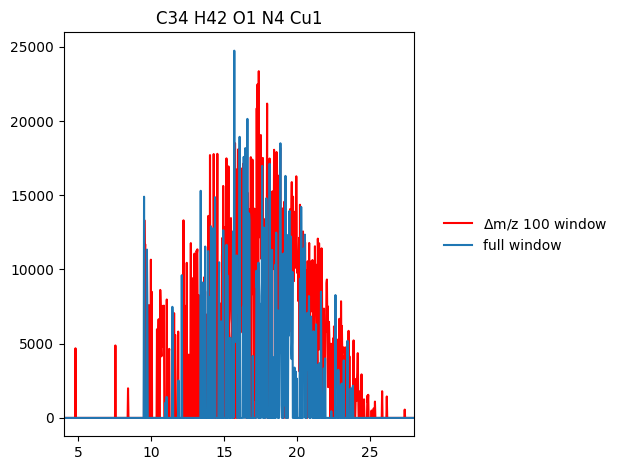

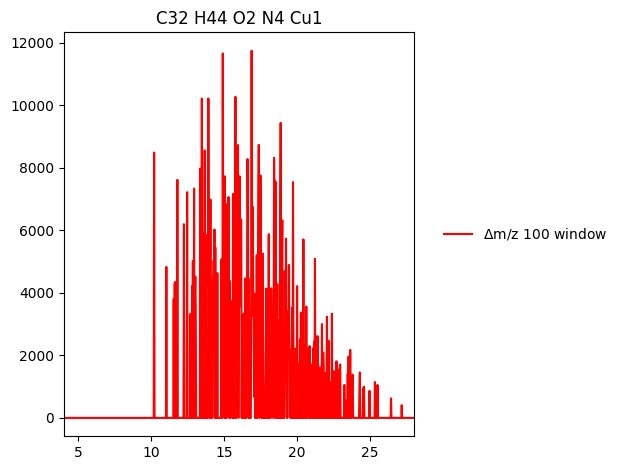

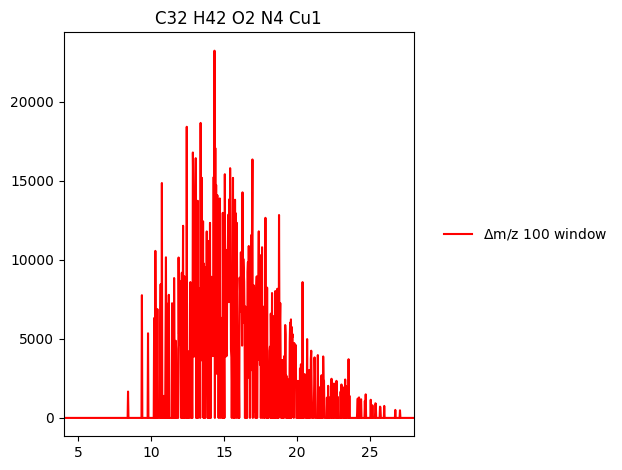

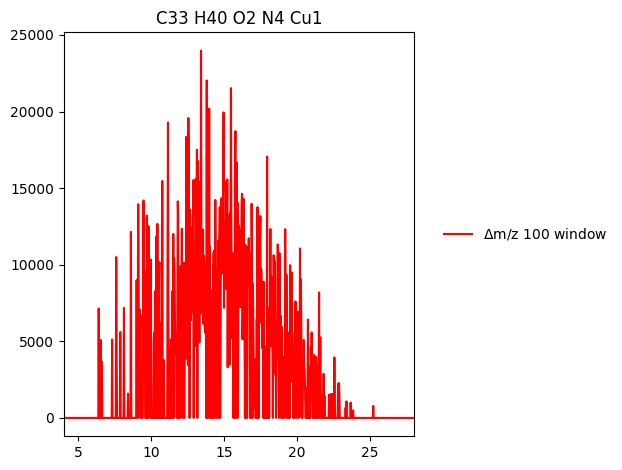

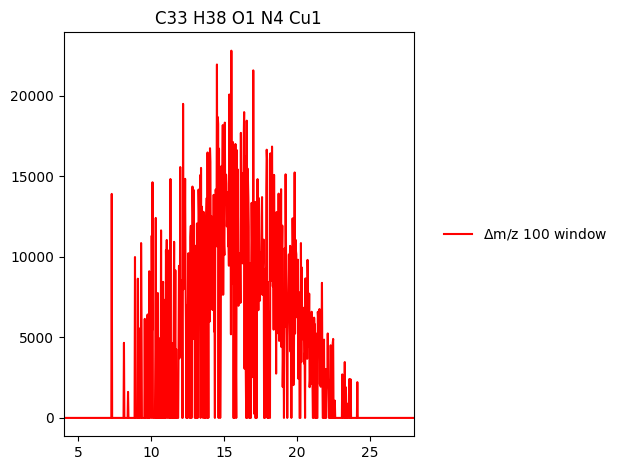

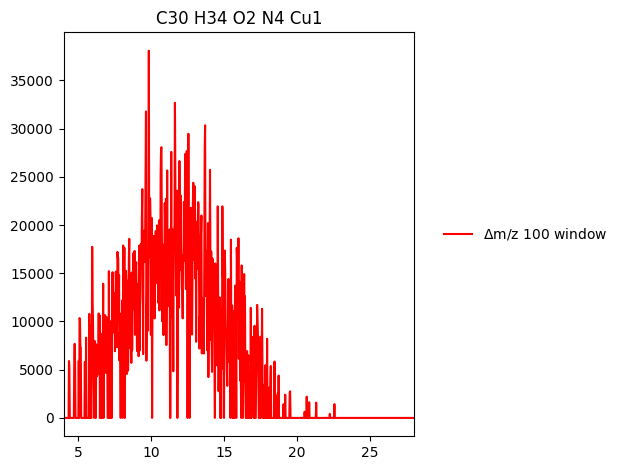

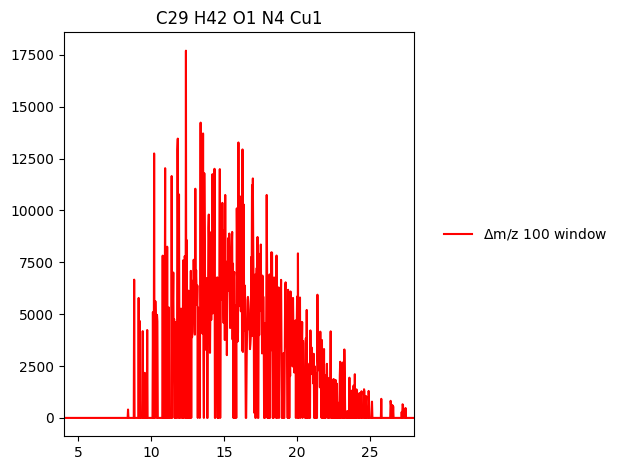

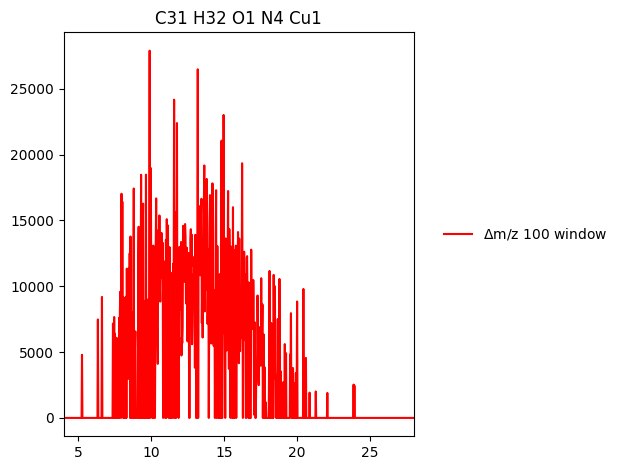

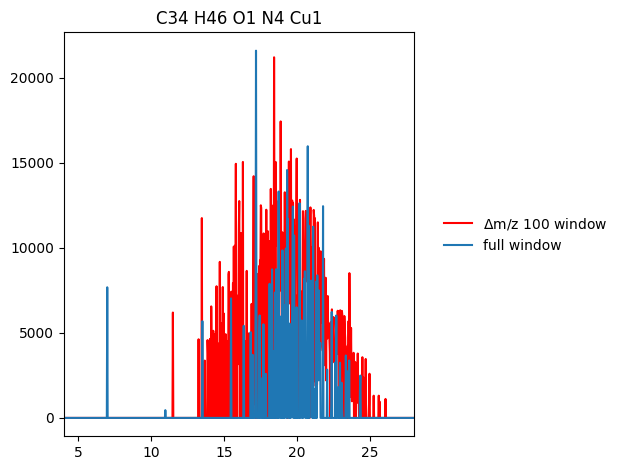

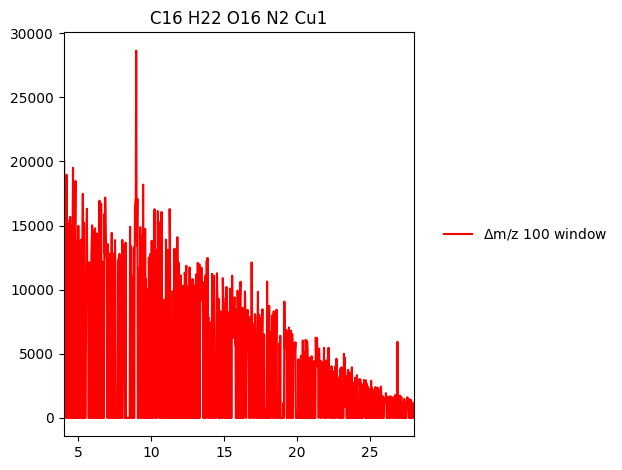

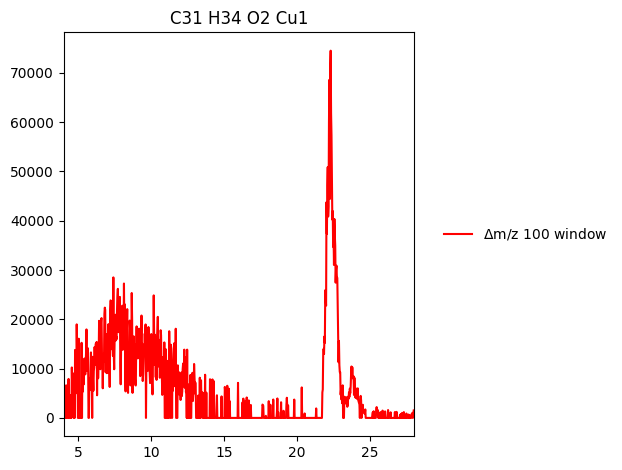

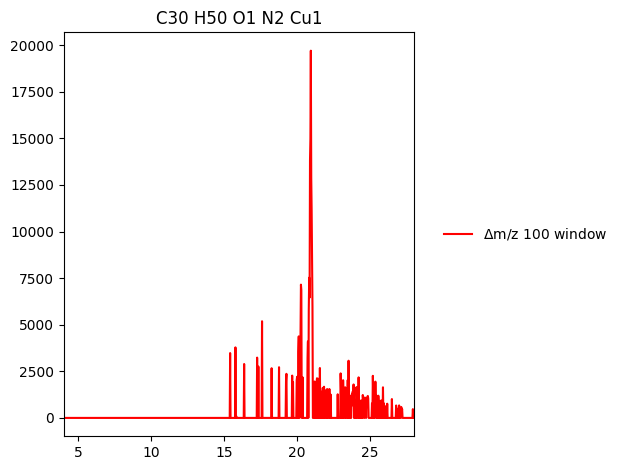

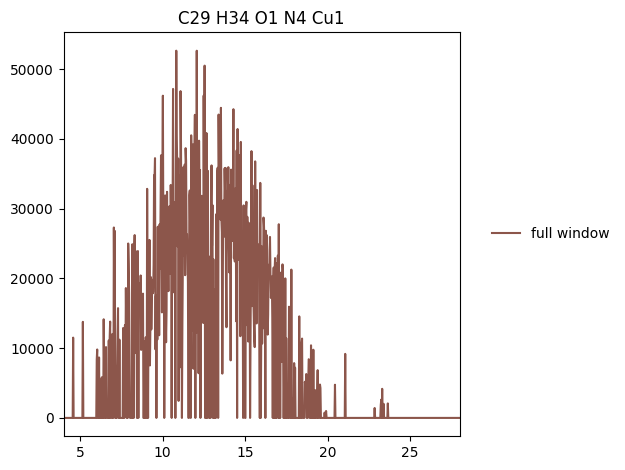

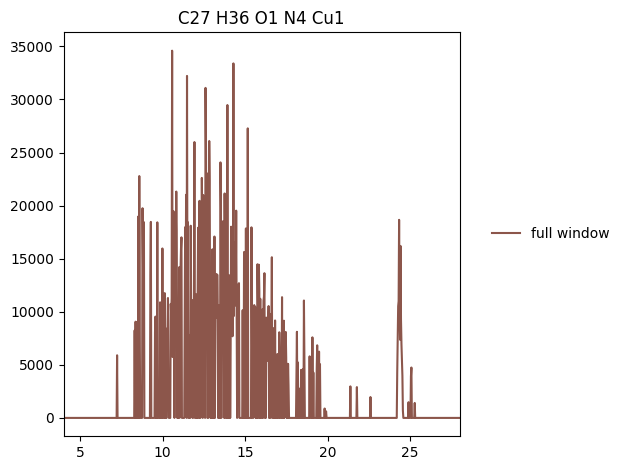

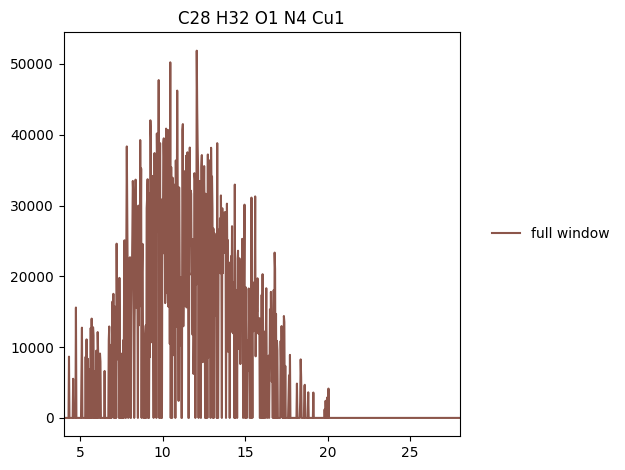

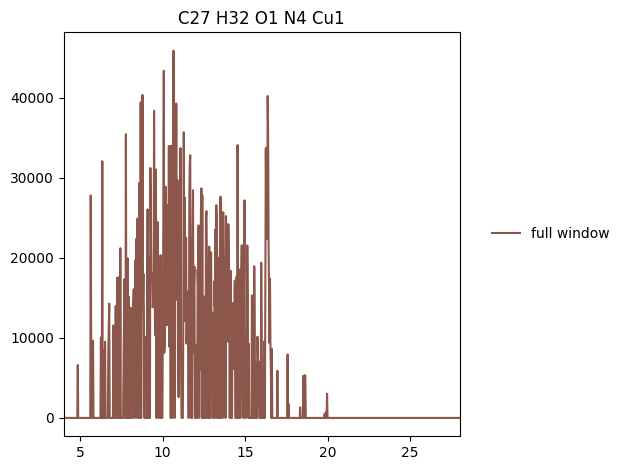

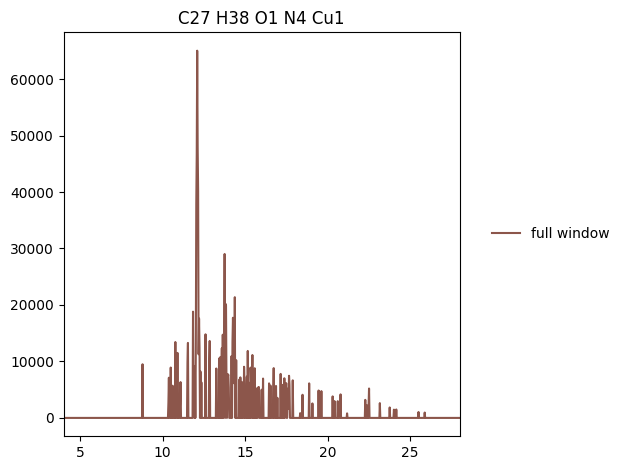

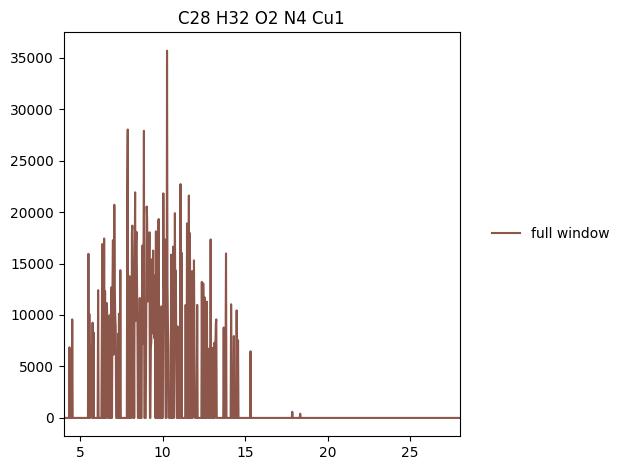

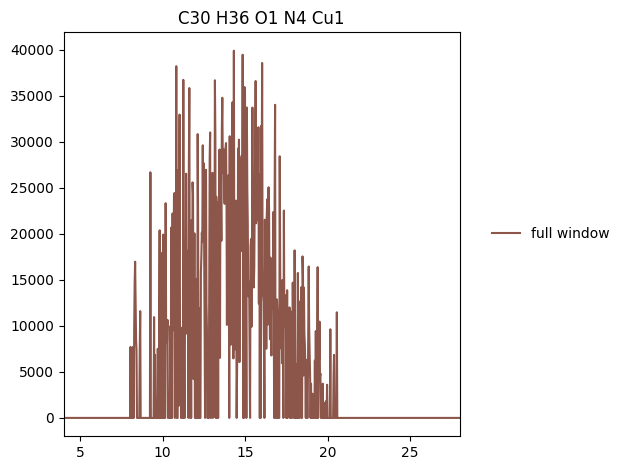

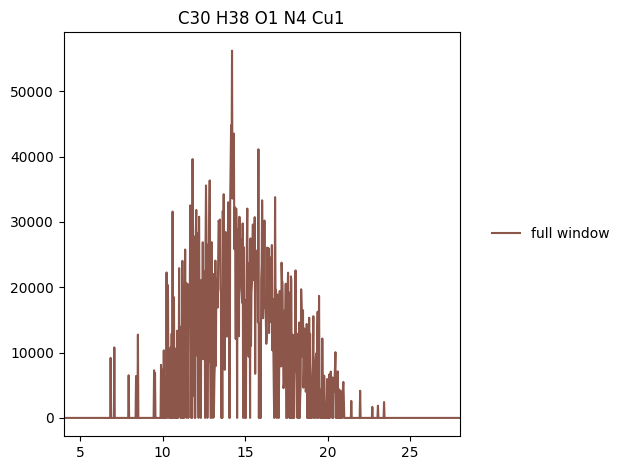

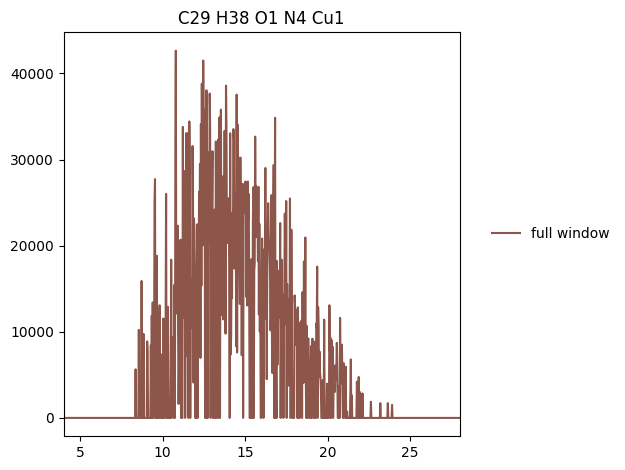

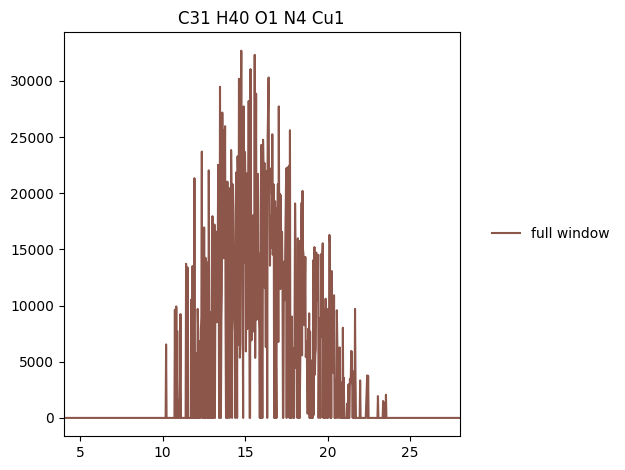

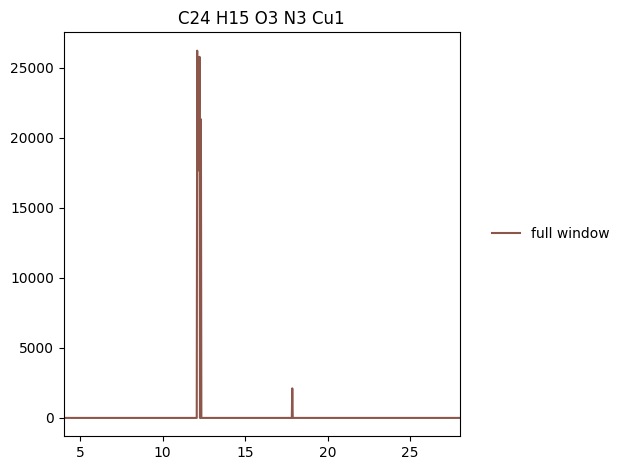

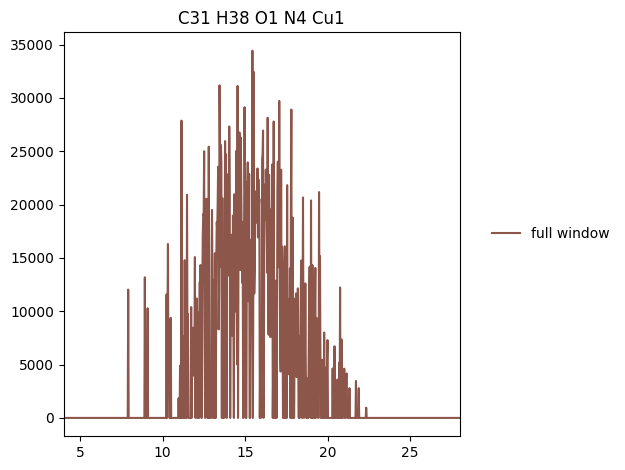

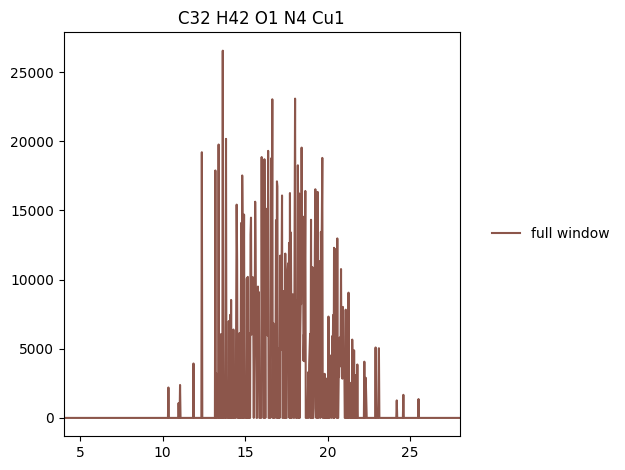

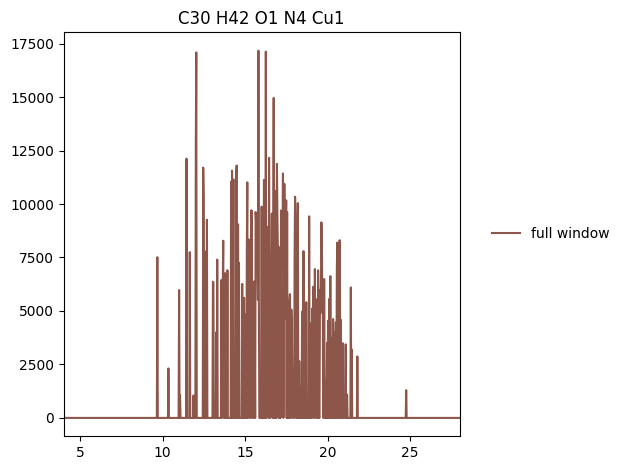

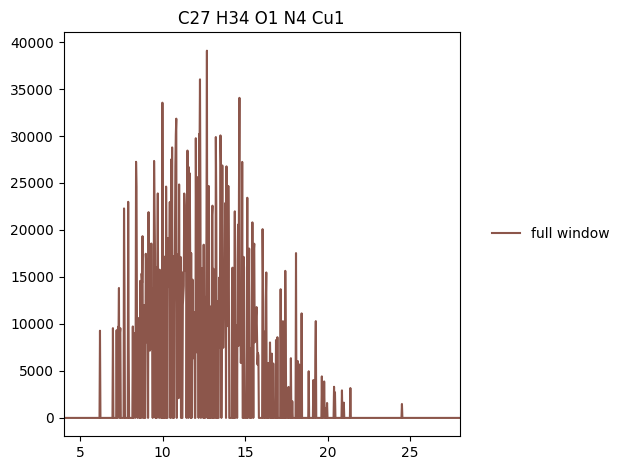

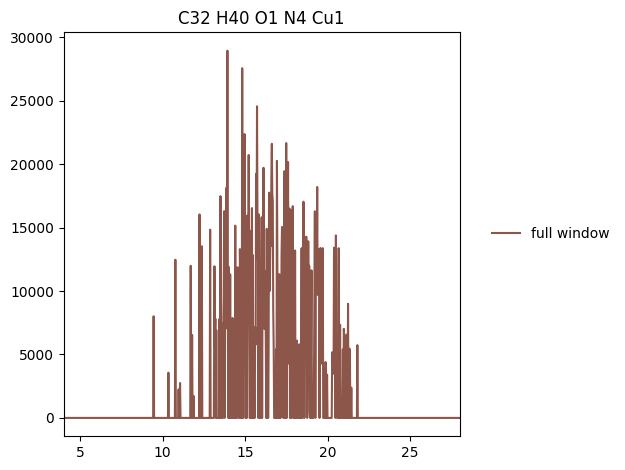

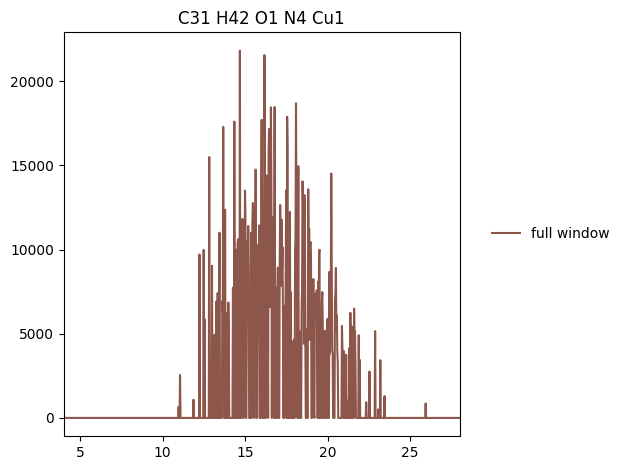

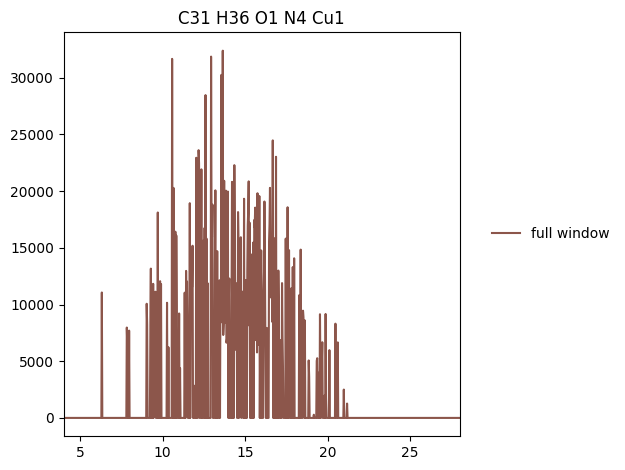

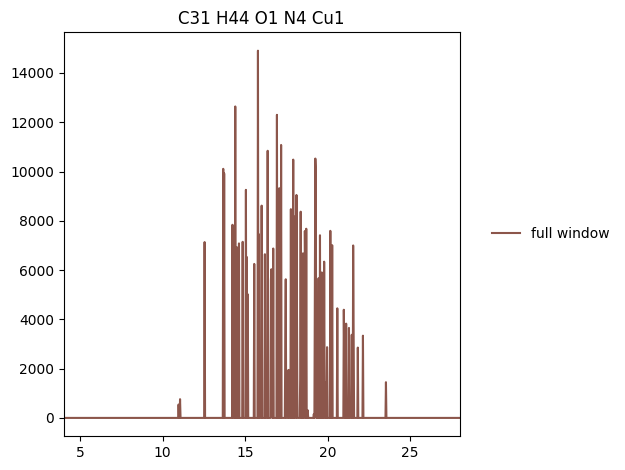

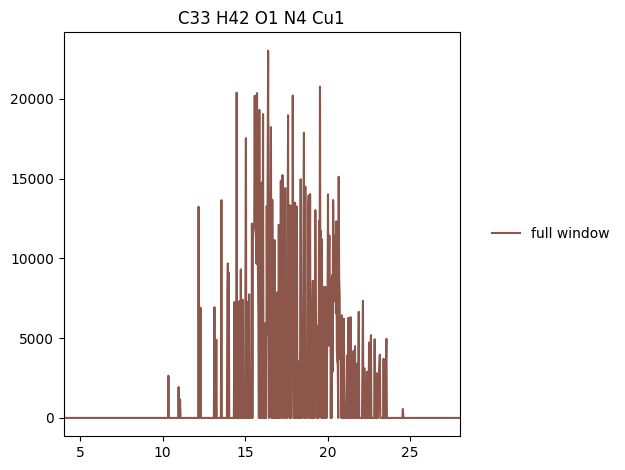

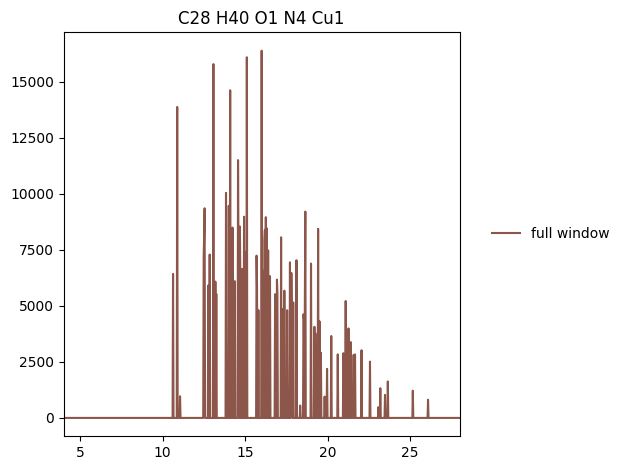

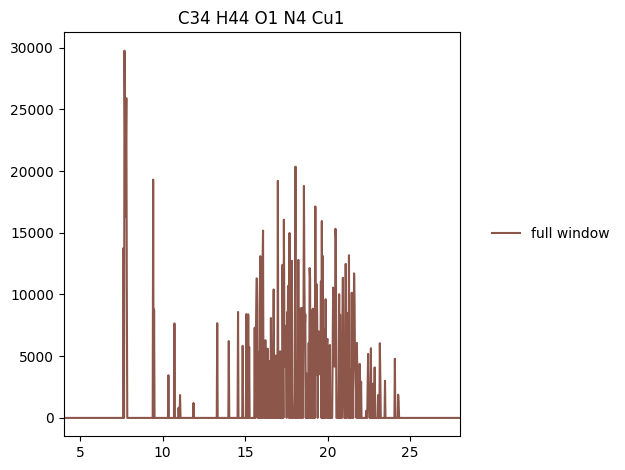

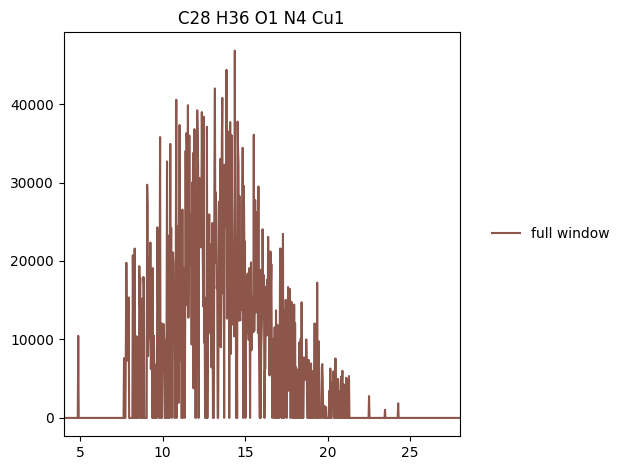

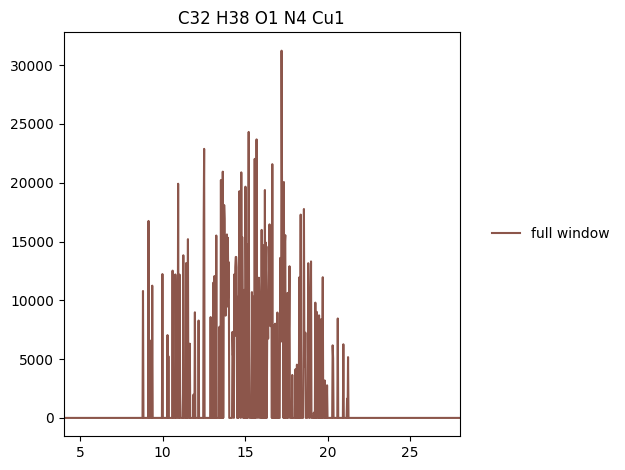

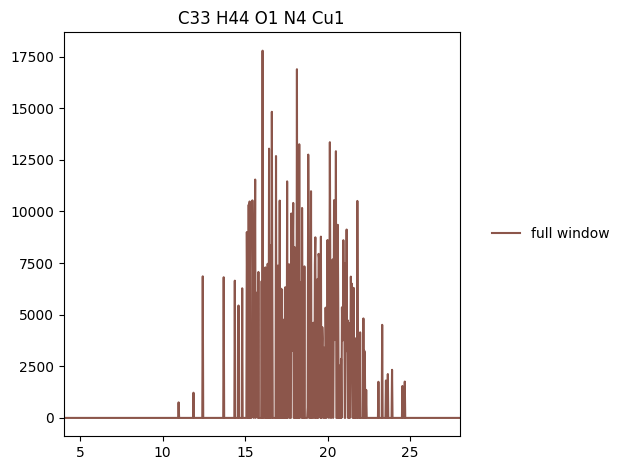

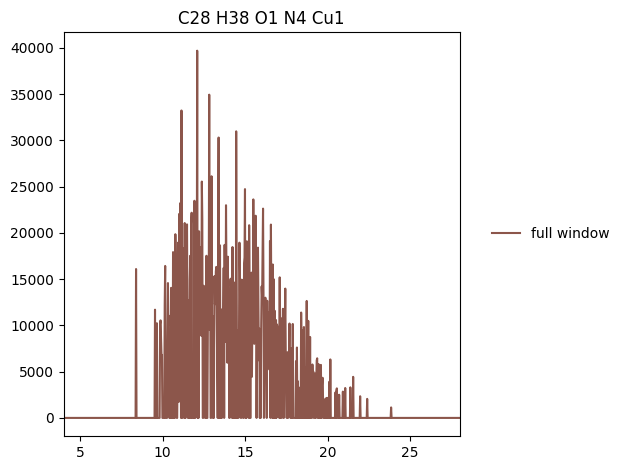

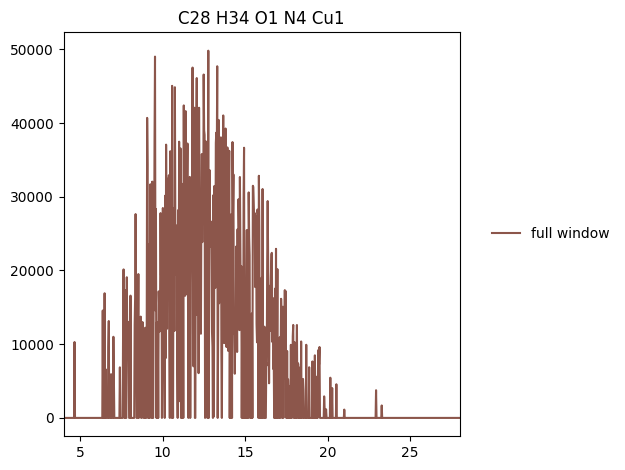

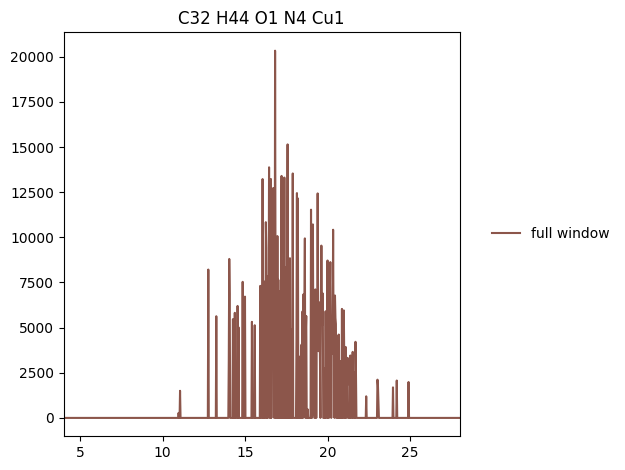

In [72]:
from matplotlib.backends.backend_pdf import PdfPages

icpms_file = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/spring_ENV.csv'
icpms = pd.read_csv(icpms_file, sep=';',header=1)


metals = ['63Cu', '115In']

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_100mz_fullmz-dec1.pdf')

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Cu ICPMS Trace')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICPMS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(2,30)
fig.tight_layout()
pdf.savefig()

for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

for mf in fullmz_EICdic:   

    if mf not in mz100_EICdic:

        fig, ax = plt.subplots()

        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        inds = np.where(np.asarray(eic2t)<28)

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C5', label = 'full window')

        ax.set_xlim(4,28)
        ax.set_title(mf)
        ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
        fig.tight_layout()
        pdf.savefig()

pdf.close()

In [ ]:
# C23 H32 O3 Cu

sub = combo[combo['Molecular Formula'] == 'C23 H32 O3 Cu1']

sub

In [ ]:
for i in range(len(mz100_cu_limited_err.index)):

    mf = mz100_cu_limited_err['Molecular Formula'].iloc[i]
    
    if mf in mzfull_cu_limited_err['Molecular Formula'].values:

        print('\n\nNarrow m/z:')
        print(mz100_cu_limited_err.iloc[i,:])

        ind = mzfull_cu_limited_err[mzfull_cu_limited_err['Molecular Formula'] == mf].index 
        print('\nFull m/z:')
        print(mzfull_cu_limited_err.loc[ind].squeeze())




In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_100mz_fullmz-dec5.pdf')


for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

for mf in fullmz_EICdic:   

    if mf not in mz100_EICdic:

        fig, ax = plt.subplots()

        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        inds = np.where(np.asarray(eic2t)<28)

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C5', label = 'full window')

        ax.set_xlim(4,28)
        ax.set_title(mf)
        ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
        fig.tight_layout()
        pdf.savefig()

pdf.close()

In [ ]:
refs = pd.read_csv('/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref')
#r45 = refs[(refs['m/z value']>=400) & (refs['m/z value']<=500)]

print(refs[' m/z value'])


In [ ]:

fig, ax2 = plt.subplots()

sns.histplot(refs, x=' m/z value',  ax=ax2)
ax2.set_ylabel('Count')
#ax2.set_xlim(400,600)
#legend = ax2.get_legend()
#handles = legend.legendHandles
#labels = ['100 m/z','1000 m/z']
#ax2.legend_.remove()

fig = plt.gcf()

#fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

plt.show()